# K-index Calculation for each day using FMI method

This program is a K-index Calculation for one UTC day (UTC 24 hours) period based on FMI algorithm for regional geomagnetic analysis. It is written in Python using Google's Colab and it can be run in Google's Colab (recommended) or Jupyter notebook.

The program will read magnetometer dataset from INTERMAGNET https://intermagnet.org and generate a excel file/ csv files with K-index and SR_curve values.

The process are

1.   Screening the dataset and removing the outliers
2.   Estimating Solar regular ($S_R$) variation of the geomagnetic field by FMI
3.   Calculating the Kindex

The magnetometer dataset is from INTERMAGNET https://intermagnet.org and the data of each observatory can be downloaded using its IAGA code.


---

---

The orignal software and reference papers are available as below.

FMI-method for K-indices computation
provided by L. Hakkinen, Finnish Meteorolical Institute, Finland [K indices softwares](http://isgi.unistra.fr/softwares.php)


[Stankov, Stanimir & Stegen, K. & Warnant, René. (2010). Local Operational Geomagnetic Index K Calculation (K-LOGIC) from digital ground-based magnetic measurements](https://www.researchgate.net/publication/280733517_Local_Operational_Geomagnetic_Index_K_Calculation_K-LOGIC_from_digital_ground-based_magnetic_measurements)

Programmer: Lin M. Myint (linminmin.my@kmitl.ac.th)

---
---



## Step 0: Importing Python's Libraries and Functions

### Importing libraries


In [ ]:
# installing required modules and libaries
import pandas as pd
import scipy as sci
import matplotlib.pyplot as plt
import numpy as np
import glob # tothe pathnames management
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import ftplib
import os, sys, re
import gzip
from scipy.interpolate import InterpolatedUnivariateSpline
from urllib import request
from urllib.error import URLError
from contextlib import ExitStack
import shutil

### Functions used in FMI algorithm

**Range_Kindex Function **

- Generate the range classes table according to K9_Limit value which is depend on the station's location
- Map the variation range in 3 hour to the K-index value according to the range classes table

**Usage:** `K = Rang_Kindex(x, K9_limit)`

> K = K-index : integer (0-9)

> x = magnetic field varaition: float (nT)

> K9_limit = upper limit of  K9 range: float (nT)*

---

**Find_m Function**
- Find fitting lengths values in minutes $m$ relative to local time for hourly mean calculation

$ m(t_i) = 90, t_i \in [00, 03LT) $ during night

$ m(t_i) =  60, t_i \in [03, 06LT) $ during dawn

$ m(t_i) =   0, t_i \in [06, 18LT) $ during day time hours

$ m(t_i) =  60, t_i \in [18, 21LT) $during dusk

$ m(t_i) = 90, t_i \in [21, 24LT) $ during night

**Usage:**
`m = Find_m(x)`

> m = the duration for calculate the mean value (minutes)

> x =  local time (hour)

---
**Curve Smooth Function**

- To find the smooth curve of $S_R$ curve using FFT and iFFT

**Usage:**
`SR_curve = SR_curve_smooth(Mean_1hr_df, curve_index, HarmOrder)
`
> SR_curve = SR_curve value:  datafram with 24 float values (nT)

> Mean_1hr_df =  the 1hr mean value of magnetic field for one day: data frame (nT)

> curve_index = index array: timestamp

> HarmOrder = nth order: inetger







In [ ]:
# change from Range to Kindex
def Rang_Kindex(x, K9_limit):
  """
   Covert Variation Range to K-inde value

    Parameter:
    ----------
    x = magnetic field variation range within 3 hours (float)
    K9_limit = K9 lower limit value of the target station

    Returns
    ------------
    K-index (integer [0,1,..,9])

  """
  # reference value from Niemegk Observatory
  niemegk = np.array([0, 5, 10, 20, 40, 70, 120, 200, 330, 500, np.inf])
  limit_K = niemegk * K9_limit/500 # converting for specific station
  for i in range(len(limit_K)):
    if  limit_K[i] <= x < limit_K[i+1]:
      return(i)
      break
    else:
      continue

########################################################################

# Find fitting lengths and interval for hourly mean
def Find_m(x):
  """
   Find fitting lengths  for each hour mean relative to local time

    Parameter:
    ----------
    x = local time [Timestamp]

    Returns
    ------------
    m = lengths in minutes for each hour mean calculation (integer)

  """
  if 0 <=  x.hour < 3 or 21 <=  x.hour < 24:
    m = 90
  elif 3 <= x.hour < 6 or 18 <= x.hour < 21:
    m = 60
  else:
    m = 0
  return m


########################################################################
# S_R curve Smoothing using FFT and iFFT

def SR_curve_smooth(Mean_1hr_df, curve_index, HarmOrder):

  """
   Find fitting lengths  for each hour mean relative to local time

    Parameter:
    ----------
    Mean_1hr_df = data frame with hourly mean values of X and Y only
    curve_index = time index array for Sr curve
    HarmOrder = Hormonic order

    Returns
    ------------
    Sr_curve_df = data frame with smooth sr_curve with columns [''Smoothed X mean', 'Smoothed Y mean']

  """
  Sr_curve_Ser = pd.DataFrame(index=curve_index,dtype='float')
  Sr_curve_Ser['Smoothed X mean'] = np.nan
  Sr_curve_Ser['Smoothed Y mean'] = np.nan
  # Using Fast Fourier Transform and inverse Fast Fourier Transform
  HourlyMean_groups = Mean_1hr_df.groupby(pd.Grouper(freq='D'))
  time_gap = pd.Timedelta(24*60-1,unit='T')
  X_harm, Y_harm = np.zeros(24*60), np.zeros(24*60) # Mean value for each hour over fitting  area
  ReX, ReY = np.zeros(24), np.zeros(24)
  ImX, ImY = np.zeros(24), np.zeros(24)
  for idx, group in HourlyMean_groups:
    X_mean = group.iloc[:,0].values
    Y_mean = group.iloc[:,1].values
    t0 = 30 # Middepointof first hour in minutes
    t1 = 23*60 + t0 # Middepointof first hour in minutes
    # Rorate the curve so that start and en points are equal
    X_coeff = (X_mean[23] - X_mean[0])/(t1-t0)
    Y_coeff = (Y_mean[23] - Y_mean[0])/(t1-t0)
    t = t0
    for i in range(24):
      X_mean[i] = X_mean[i] - (X_coeff*(t-t0))
      Y_mean[i] = Y_mean[i] - (Y_coeff*(t-t0))
      t = t + 60

    # Compute the Fourier coefficients
    for i in range(HarmOrder):
      ReX[i] = X_mean[0]
      ImX[i] = 0.0
      ReY[i] = Y_mean[0]
      ImY[i] = 0.0
      angle = -i*(2.0*np.pi/24.0)
      for j in range(1,24,1):
        si = np.sin(j*angle)
        co = np.cos(j*angle)
        ReX[i] = ReX[i] + X_mean[j]*co
        ImX[i] = ImX[i] + X_mean[j]*si
        ReY[i] = ReY[i] + Y_mean[j]*co
        ImY[i] = ImY[i] + Y_mean[j]*si

    # Compute the inverse fourier transform taking into account only terms up to HarmOder
    t = 0
    angle = 2.0 * np.pi*(23.0/24.0)/(t1-t0)
    for i in range(24*60):
      X_harm[i] = ReX[0]
      Y_harm[i] = ReY[0]
      angle2 = (t-t0)*angle
      for j in range(1,HarmOrder,1):
        si = np.sin(j*angle2)
        co = np.cos(j*angle2)
        X_harm[i] = X_harm[i] + (2.0*(ReX[j]*co - ImX[j]*si))
        Y_harm[i] = Y_harm[i] + (2.0*(ReY[j]*co - ImY[j]*si))
      X_harm[i] = X_harm[i]/24.0 + X_coeff*(t-t0)
      Y_harm[i] = Y_harm[i]/24.0 + Y_coeff*(t-t0)
      t = t + 1
    Sr_curve_Ser.loc[idx:idx+time_gap, 'Smoothed X mean'] = X_harm
    Sr_curve_Ser.loc[idx:idx+time_gap, 'Smoothed Y mean'] = Y_harm
  return Sr_curve_Ser

### Functions to read Kp-index data file from server (For comparison only)

#### Convert Ks indices to Kp indices


Ks indices range in 28 steps from 0 (quiet) to 9 (greatly disturbed) with fractional parts expressed in thirds of a unit. A Ks-value equal to 27, for example, means 2 and 2/3 or 3-; a Ks-value equal to 30 means 3 and 0/3 or 3 exactly; and a Ks-value equal to 33 means 3 and 1/3 or 3+. The arithmetic mean of the Ks values scaled at the 13 observatories listed above gives Kp.

```
Kp = Ks2Kp(Ks)
```
parameters

'
Ks : Ks value
'

return

'
Kp : Kp value
'

#### To download the Kp file as dataframe

```
Kp_df = Kp_download(kp_target)
```
parameters

`
kp_target : Target year of Kp index
`
return

`
Kp_df : dataframe with Kp information the whole year
`

#### To mark the quiet day if Kp < 3 otherwise mark not quiet day

[Kp-index range](https://www.spaceweatherlive.com/en/help/the-kp-index)

```
Find_Quiet_day(x)
```



---



In [ ]:
# Change from Ks to Kp
def Ks2Kp(x):
  len_x = len(x)
  x = list(x)
  for i in range(0,len_x-1,2):
    if x[i] == ' ': # white space means 0
        x[i] = '0'

    if x[i+1] == '7':
      x[i] = str(int(x[i])+1)
      x[i+1]= '-'

    elif x[i+1] == '3':
      if x[i] == ' ':
        x[i] = '0'
      x[i+1]= '+'

    else:
      x[i+1]=' '
  return ''.join(x)

# To calculate Daily_Kp Sum
def DailyKpsum(x):
  x = x/10
  x_new = round(x)
  if (x - x_new ) < 0:
    sig_ch = '-'
    #x_new = x_new -1
  elif (x-x_new) > 0:
    sig_ch = r'+'
  else:
    sig_ch = r' '

  return str(x_new) + sig_ch

# Checking the quiet day in which Ks/Kp index never reach 3
def Find_Quiet_day(x):
  len_x = len(x)
  x = x.replace(' ','0')
  for i in range(0,len_x,2):
    if int(x[i]) >= 3:
      return 'No Quiet'
      break
  return 'Quiet'


# download the Kp file
def Kp_download(kp_target,kpfile_local):
  with ftplib.FTP('ftp.gfz-potsdam.de') as ftp:
    kpfile_orig = 'pub/home/obs/kp-ap/wdc/yearly/' + kp_target

    try:
      #print(ftp.getwelcome())
      ftp.login()
      with open(kpfile_local, 'wb') as fp:
        res = ftp.retrbinary('RETR ' + kpfile_orig, fp.write)
        if not res.startswith('226 Transfer complete'):
          print('Download failed')
          if os.path.isfile(kpfile_local):
            os.remove(kpfile_local)
        print('Kp index file downloading is finished')


    except ftplib.all_errors as e:
      print('FTP error', e)
      if os.path.isfile(kpfile_local):
        os.remove(kpfile_local)

def Kp_read(kpfile_local):
  # Create a dataframe
  kp_df = pd.read_csv(kpfile_local ,index_col=None,header=None, names=['Draft'],encoding='unicode_escape')
  # separating the data into each columns
  kp_df['Date_UT'] = kp_df['Draft'].apply(lambda x: x[0:6])
  kp_df['Date_UT'] = pd.to_datetime(kp_df['Date_UT'].apply(lambda x: re.sub(r'\s','0',x)), yearfirst=True)
  kp_df['BSRnum'] = kp_df['Draft'].apply(lambda x: x[6:10])
  kp_df['numDayB'] = kp_df['Draft'].apply(lambda x: x[10:12])
  kp_df['Ks_3hr'] = kp_df['Draft'].apply(lambda x: x[12:28])
  kp_df['DialyKs_sum'] = kp_df['Draft'].apply(lambda x: x[28:31]).astype(int)
  kp_df['Ap_3hr'] = kp_df['Draft'].apply(lambda x: x[31:55])
  kp_df['DialyAp_sum'] = kp_df['Draft'].apply(lambda x: x[55:58])
  kp_df['Cp']= kp_df['Draft'].apply(lambda x: x[58:61])
  kp_df['C9']= kp_df['Draft'].apply(lambda x: x[61])
  kp_df.drop(columns='Draft', inplace=True)
  kp_df.set_index('Date_UT',inplace=True)
  kp_df.index.freq = 'D'
  kp_df['Kp_3hr'] = kp_df['Ks_3hr'].apply(lambda x: Ks2Kp(x))
  kp_df['DialyKp_sum'] = kp_df['DialyKs_sum'].apply(lambda x: DailyKpsum(x))
  kp_df['Quiet_day'] = kp_df['Ks_3hr'].apply(lambda x: Find_Quiet_day(x))
  #kp_df[['Kp_3hr','DialyKp_sum']].info()
  return kp_df

In [ ]:
# https://imag-data.bgs.ac.uk/GIN_V1/GINForms2
#
#
#----------------------------------------------------------------------
# upd_op_co:         Increment and serialize the operation count
# Input parameters:  op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def upd_op_co(op_count):
  op_count = op_count + 1
  with open('counter.dat', 'w') as f:
    f.write('%d' % op_count)
  return op_count

#----------------------------------------------------------------------
# safemd:            Safely create a folder (no error if it already exists)
# Input parameters:  folder the directory to create
#                    op_number the operation number for this call
#                    op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def safemd (folder, op_number, op_count):
  if op_number >= op_count:
    if op_number == 0:
      print ('Creating directories...')
    try:
      os.makedirs (folder, exist_ok=True)
    except OSError:
      print ('Error: unable to create directory: ' + str(folder))
      sys.exit (1)
    op_count = upd_op_co (op_count)
  return op_count

#----------------------------------------------------------------------
# getfile:           Download a file from a web server
# Input parameters:  url URL to download from
#                    local_file local file to download to
#                    n_retries number of retries to do
#                    op_number the operation number for this call
#                    gin_username the username of the GIN (or empty string)
#                    gin_password the username of the GIN (or empty string)
#                    proxy_address address of proxy server (or empty string)
#                    n_folders the number of folders to create
#                    n_downloads the number of files to download
#                    op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def getfile (url, local_file, n_retries, op_number, gin_username,
             gin_password, proxy_address, n_folders,
             n_downloads, op_count):
  if op_number >= op_count:
    # tell the user what's going on
    percent = ((op_number - n_folders) * 100) / n_downloads
    print ('%d%% - downloading file: %s' % (percent, local_file))

    # remove any existing file
    try:
      os.remove (local_file)
    except FileNotFoundError:
      pass
    except OSError:
      print ('Error: unable to remove file: ' + str(local_file))
      sys.exit (1)

    # handle authentication and proxy server
    proxy = auth = None
    if len (proxy_address) > 0:
      proxy = req.ProxyHandler({'http': proxy_address, 'https': proxy_address})
    if len (gin_username) > 0:
      auth = req.HTTPBasicAuthHandler()
      auth.add_password (realm=None,
                         uri='https://imag-data.bgs.ac.uk/GIN_V1',
                         user=gin_username,
                         passwd=gin_password)
    if url.startswith ('https'):
      default_handler = request.HTTPSHandler
    else:
      default_handler = request.HTTPHandler
    if auth and proxy:
      opener = request.build_opener(proxy, auth, default_handler)
    elif auth:
      opener = request.build_opener(auth, default_handler)
    elif auth:
      opener = request.build_opener(proxy, default_handler)
    else:
      opener = request.build_opener(default_handler)

    # download the file
    success = False
    while (not success) and (n_retries > 0):
      try:
        with opener.open (url) as f_in:
          with open (local_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out, 4096)
        success = True
      except (URLError, IOError, OSError):
        n_retries -= 1
    if not success:
      print ('Error: cannot download ' + local_file)
      sys.exit (1)

    # rename IAGA-2002 files
    dt = None
    try:
      with open(local_file, 'r') as f:
        for line in f.readlines():
          if re.search ('^ Data Type', line):
            dt = line[24:25].lower()
    except (IOError, OSError):
      pass
    if dt:
      if not dt.isalpha():
        dt = None
    if dt:
      new_local_file = local_file[:len(local_file) - 7] + dt + local_file[len(local_file) - 7:]
      try:
        os.remove (new_local_file)
      except (FileNotFoundError, OSError):
        pass
      try:
        os.rename (local_file, new_local_file)
      except (IOError, OSError):
        print ('Warning: unable to rename ' + local_file + ' to ' + new_local_file)
    else:
      print ('Warning: unable to determine data type for renaming of ' + local_file)

    op_count = upd_op_co (op_count)
  return op_count, new_local_file


### Enter the date and the station's IAGA code for K-index calculation

Follow the below steps


1. Click the INTERMANET link https://intermagnet.org/metadata/#/imos to look the list of stations.

2. Check the data available at https://intermagnet.org/new_data_download.html


3. Enter a station the station's IAGA codefor K-index calculating  

4. Enter the date interested to generate K-index


Note: you can enter more than 1 in the number of days (num_day) if you want to calculate more than one day.

In [ ]:
#@title Enter date and Station IAGA code to be studied { vertical-output: true }

date_input = '2024-05-10' #@param {type:"date"}
stat_name = 'GUA' #@param {type:"string"}

num_day = 3 #@param {type:"integer"}

K9_val = 500 #@param {type:"integer"}

## Step 1: Data Reading and Preprocessing

### Read magnetometer dataset as Dataframe and Screening

1. Downloading the magnetometer dataset files of the day interested for calculation.
2. Reading K9_limit and longitude for local time calculation

The files will be downloaded to a folder name Magnetometerdata at local space.

In [ ]:
# Downloading the data
#!/usr/bin/env python3
# download.py: Download geomagnetic data from Edinburgh GIN
#
# This script is designed to download geomagnetic data
# from the Edinburgh INTERMAGNET Geomagnetic Information Node.
# To use the script, follow these steps:
#
# 1.) Create a new directory.
# 2.) Move to the new directory and copy the script there.
# 3.) Execute the script by typing 'python3 download.py'.
#
# The script keeps track of its progress through the list of files
# to download. If it fails at any time, you can restart it and it will
# resume at the point where it failed.
#
#
# Configurable parameters - these variables control use of proxy
# servers at the users site - there's also an option to use
# authentication - change them as required (though the
# defaults should work OK)
gin_username = ''
gin_password = ''
proxy_address = ''
n_retries = 4
date_input = pd.Timestamp(date_input) # change to Timestamp from string
year_month = date_input.strftime('%Y %B')
total_days =  num_day + 2 # need day before and after
date_start = date_input - pd.Timedelta(1,'day') # start date (one day before)
date_end = date_input + pd.Timedelta(total_days-2,'day') # end date (one day after)
time_start = date_input # the start time (minute) of target date/month
time_end = date_input + pd.to_timedelta(total_days-2,'day') - pd.to_timedelta(1,'minute') # the last time (minute) of traget date/month
loc_folder =  os.path.join(os.getcwd(),'Magnetometerdata', stat_name+ date_input.strftime('%Y%m')) # folder to save
stat_name_l = stat_name.lower() # name of station
Geo_Lo, K9_limit = 0, 0 #

if num_day == 1:
  dur_date = time_start.strftime('%Y %B %d')
else:
  dur_date =  time_start.strftime('%Y %b %d')+' to '+time_end.strftime('%b %d') # duration of time

for i in range(total_days):
  try:
    with open ('counter.dat') as f: # download the data
      op_count = int(f.read())
      print('Information: resuming download after previous failure')
  except (IOError, ValueError, OSError):
    op_count = 0
  n_folders = 1
  n_downloads = 1

  folder = loc_folder
  op_count = safemd(folder, 0, op_count)
  date_temp = date_start + pd.Timedelta(i,'day')
  loc_file = os.path.join(loc_folder,'m'+ date_temp.strftime('%Y%m%d.') + stat_name_l)
  # ser_link = 'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=definitive&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
  ser_link = 'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=adj-or-rep&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
  op_count, new_loc_file = getfile (ser_link, loc_file, n_retries, 1, gin_username, gin_password, proxy_address, n_folders, n_downloads, op_count)
  # for any file
  #'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=adj-or-rep&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
 # For defintive fileonly
  # https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=definitive&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
    # tidy up
  print ('100% - data download complete')
  os.remove ('counter.dat')
  if i == 1: # read the first 30 lines from the file for checking
    with open(new_loc_file, "rb") as fr:
      for j in range(28):
        line = fr.readline()
        if b'K9-limit' in line:
          K9_limit  = line.decode('utf-8').split()[2]
          K9_limit = int(K9_limit) # Change K9 limit according to the information
          #print(f'K9 lower limit is {K9_limit}')
        if b'Geodetic Longitude' in line:
          Geo_Lo = line.decode('utf-8').split()[2]
          Geo_Lo = float(Geo_Lo)
        if b'DATE' in line:
          line_no = j
        #print(line) # display header information of file
      fr.seek(0)
print(f'K9 lower limit is {K9_limit}')
  # Calculate the local time difference from longitude
if Geo_Lo < 180:
  LT_diff = Geo_Lo/15 # for East
else:
  LT_diff = (180 - Geo_Lo)/15 # for West
if K9_limit  == 0:
  print("There is no K9 limit value.")
  K9_limit  = K9_val
  # sys.exit("Error message")

Creating directories...
0% - downloading file: /content/Magnetometerdata/GUA202405/m20240509.gua
100% - data download complete
Creating directories...
0% - downloading file: /content/Magnetometerdata/GUA202405/m20240510.gua
100% - data download complete
Creating directories...
0% - downloading file: /content/Magnetometerdata/GUA202405/m20240511.gua
100% - data download complete
Creating directories...
0% - downloading file: /content/Magnetometerdata/GUA202405/m20240512.gua
100% - data download complete
Creating directories...
0% - downloading file: /content/Magnetometerdata/GUA202405/m20240513.gua
100% - data download complete
K9 lower limit is 0
There is no K9 limit value.


#### Creating dataframes for process and Data Preprocessing

If the bad record length exceeds a certain threshold, the bad records are discarded or repaired by some sort of approximation. The program will remove the data which are more than threadhold value. In our procedure, the number of standard deviations (σ) from the local means that define a spike is set to 2.5σ. The pikes are then discarded (no interpolation allowed) and their position is treated as a gap.  

In [ ]:
# Create the list of files stored at local drive and check
target_file =os.path.join(loc_folder, 'm'+'*.'+ stat_name_l) # change to filename)
csv_files = glob.glob(target_file) # read all file name
if len(csv_files) == total_days :
  print(r'Selected from ' + dur_date) #date_input.strftime('%Y %b %d') )
  print(f'The number of days with data is {len(csv_files)} including one day before and after the target day(s).')
elif len(csv_files) in range(1, total_days-2) :
  print(r'There are some days without data')
  print(f'The number of days with data is {len(csv_files)}')
else:
  print(r'There is no data for such time period')

# read each file name from list and read them dataframe.
if len(csv_files) > 0:
  csv_files.sort() # sort the file as date
    # column names (need to rewrite read from file)
  col_names =['YYYY-MM-DD_UT','UT', 'DOYUT', 'X (nT)','Y (nT)', 'Z (nT)','G']
    # Read all file, convert them to Dataframe and add to a list of Dataframe
  list_dfs = [pd.read_csv(f_name, delim_whitespace=True,  skiprows=line_no+1, index_col=None,
                          names=col_names, encoding= 'unicode_escape') for f_name in csv_files] # encoding= 'unicode_escape'
  Mag_df = pd.DataFrame() # A dataframe to keep all Magnetic Date
  for i in range(len(list_dfs)): # temp_df in enumerate(list_dfs):
      # Convert the date time format to YYYY-MM-DD HH:MM:SSS using to_datetime and to_timedelta (difference in time)
    date_temp = date_start + pd.Timedelta(i,'day')
    list_dfs[i]['YYYY-MM-DD_UT'] = pd.to_datetime(list_dfs[i]['YYYY-MM-DD_UT'])+pd.to_timedelta(list_dfs[i]['UT']).dt.round("s")
    list_dfs[i].rename(columns={"YYYY-MM-DD_UT":"DateTime_UT"},errors='raise',inplace=True) # Change the column name
    list_dfs[i].set_index('DateTime_UT',inplace=True) # set as index column
    if list_dfs[i].index.duplicated().any(): # delete any dublicated number
      print("There is duplicated data to be dropped.")
      list_dfs[i].drop_duplicates(keep="first",inplace=True)
    dt = (list_dfs[i].index[-1]- list_dfs[i].index[0])
    if list_dfs[i].shape[0] != dt.total_seconds()/60 +1:
     list_dfs[i] = list_dfs[i].resample('T',base=0).mean() # make every 1 minutes if there is data gap, add nan
     list_dfs[i].interpolate(method='linear',limit_direction='forward',inplace=True)
     print(f"Data gap is replace by interpolation method for day {i+1}")
    if dt.total_seconds()/60 +1 != 24 * 60:
     print(f"Data is not complete in day {i+1}")
    # to add NAN data frame if the data is missing at begining and end
    if list_dfs[i].index[0] != date_temp:
      time_gap = list_dfs[i].index[0] - date_temp
      temp_idx = pd.date_range(start=date_temp, end=date_temp + time_gap - pd.to_timedelta(1,'minute'), freq='T')
      temp_df = pd.DataFrame(columns=list_dfs[i].columns,index=temp_idx,dtype= float)
      list_dfs[i] = pd.concat([temp_df, list_dfs[i]])
      print(f'There is no data at the beginning {date_temp}')
      del temp_df, temp_idx, time_gap
    day_end = date_temp + pd.to_timedelta(1,'day') - pd.to_timedelta(1,'minute')
    if list_dfs[i].index[-1] != day_end:
      time_gap = day_end - list_dfs[i].index[-1]
      temp_idx = pd.date_range(start=list_dfs[i].index[-1] + pd.to_timedelta(1,'minute'), end = day_end, freq='T')
      temp_df = pd.DataFrame(columns=list_dfs[i].columns,index=temp_idx,dtype= float)
      list_dfs[i] = pd.concat([list_dfs[i], temp_df])
      print(f'There is no data at the end {date_temp}')
      del temp_df, temp_idx, time_gap


else: print("Sorry, There is no file.")


# Removing the outliner more than 3 * delta
mag_col = ['X (nT)','Y (nT)', 'Z (nT)','G']
temp_df = pd.DataFrame()
for i in range(len(list_dfs)):
  list_dfs[i] = list_dfs[i].replace(99999.00,np.nan)
  list_dfs[i] = list_dfs[i].replace(-9999.00,np.nan)
  temp_df = list_dfs[i][mag_col].copy()
  mean_t = temp_df.mean()
  std_t = temp_df.std()
  z_score = np.abs(temp_df - mean_t)/std_t
  list_dfs[i] = list_dfs[i][z_score <= 3.5]
del temp_df

Selected from 2024 May 10 to May 12
The number of days with data is 5 including one day before and after the target day(s).


<ipython-input-18-e14bafda795d>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  list_dfs = [pd.read_csv(f_name, delim_whitespace=True,  skiprows=line_no+1, index_col=None,
<ipython-input-18-e14bafda795d>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  list_dfs = [pd.read_csv(f_name, delim_whitespace=True,  skiprows=line_no+1, index_col=None,
<ipython-input-18-e14bafda795d>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  list_dfs = [pd.read_csv(f_name, delim_whitespace=True,  skiprows=line_no+1, index_col=None,
<ipython-input-18-e14bafda795d>:19: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  list

#### Checking the magnetic fields of all downloaded dataset

Gaps in the graphs represent no data available.

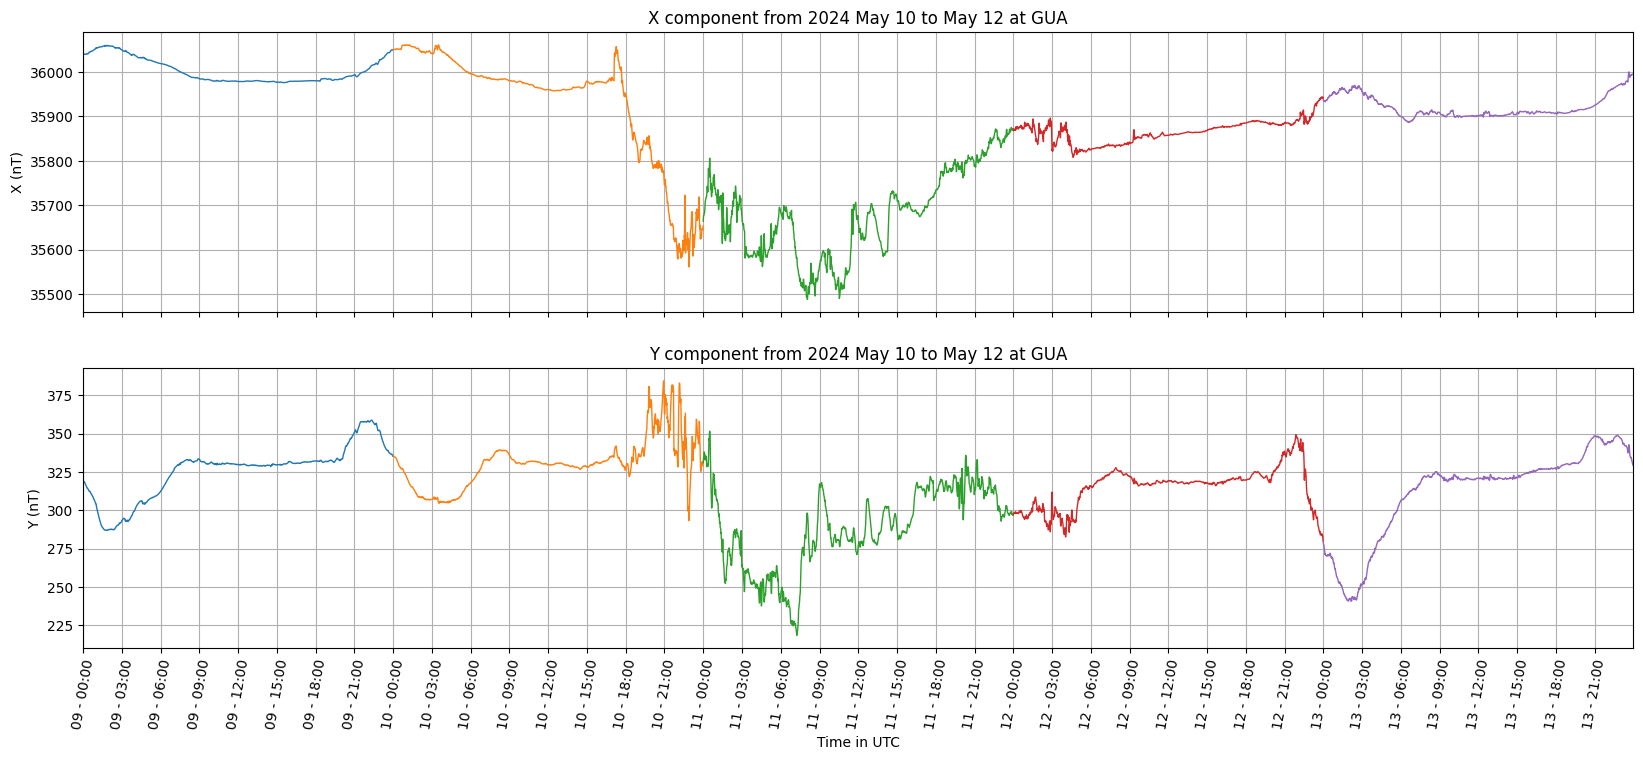

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(20.0,8.0), sharex=True) #figsize=(20.0,8.0)
for i, temp_df in enumerate(list_dfs): # for the target days including extr days
    ax[0].plot(temp_df.index,temp_df['X (nT)'],linewidth=1)
    ax[1].plot(temp_df.index,temp_df['Y (nT)'],linewidth=1)


ax[0].set( ylabel='X (nT)', title= 'X component from ' + dur_date + ' at ' + stat_name)
ax[1].set(xlabel='Time in UTC', ylabel='Y (nT)', title= 'Y component from ' + dur_date + ' at ' + stat_name)

ax[0].set_xlim(list_dfs[0].index.min(), list_dfs[-1].index.max())
ax[1].set_xlim(list_dfs[0].index.min(), list_dfs[-1].index.max())
ax[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
plt.setp(ax[1].get_xticklabels(), rotation=80)
ax[0].grid()
ax[1].grid()
plt.show()

### Removing the daily median (secular variation) from the X & Y-component

Remove the dailay median from X/Y component to get residual X/Y component

Calculate the median, mean and standard deviation of X/Y-component after removing daily median in the whole month for data screening

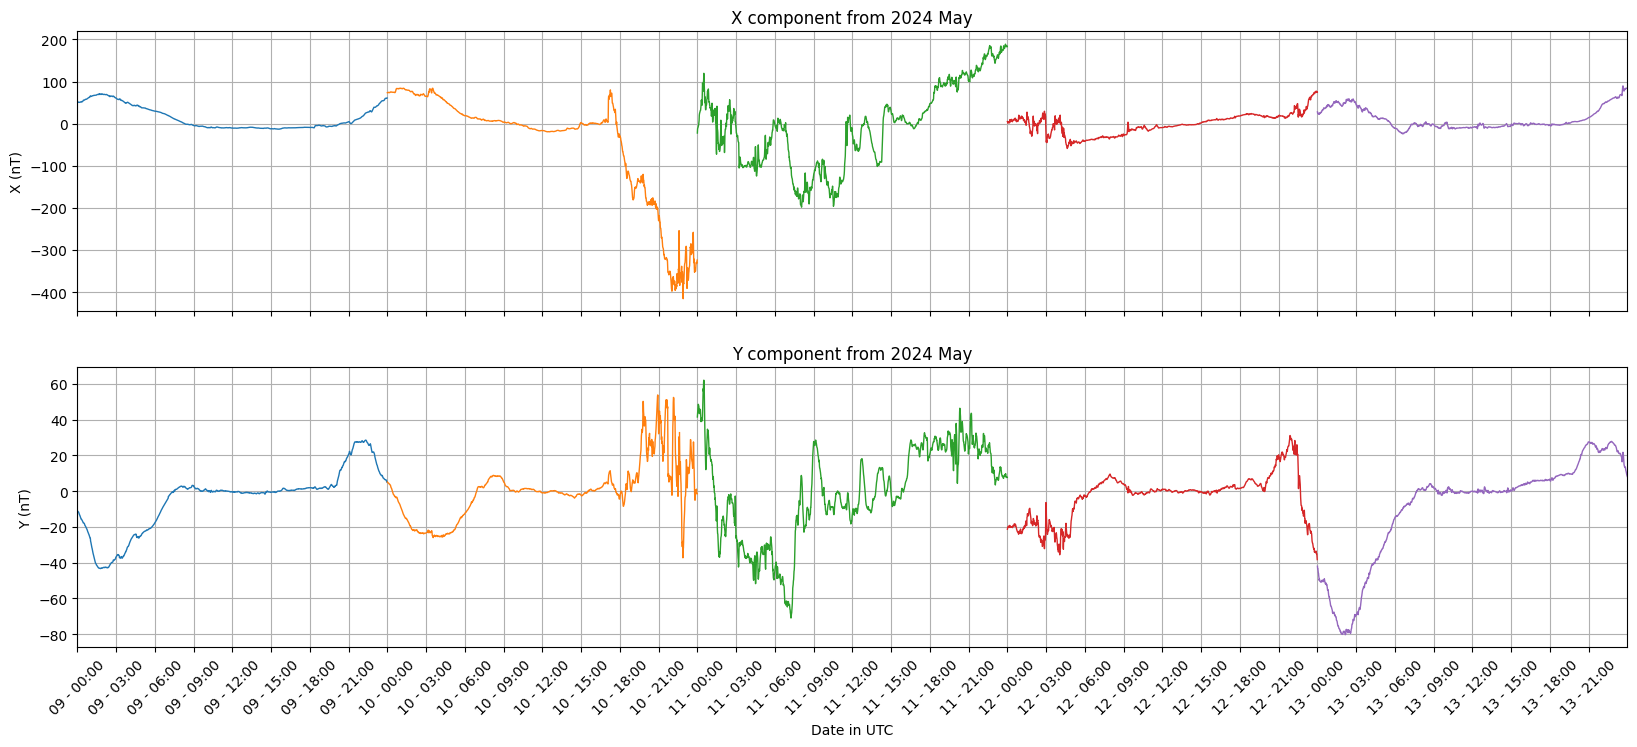

In [ ]:
mag_col = ['X (nT)','Y (nT)', 'Z (nT)','G']
Mag_df = pd.DataFrame() # A dataframe to keep all Magnetic Date
for i in range(len(list_dfs)):
  temp_df = list_dfs[i]
  temp_df.loc[:,mag_col] = temp_df.loc[:,mag_col] -temp_df.loc[:,mag_col].median()
  Mag_df = pd.concat([Mag_df, temp_df])

Mag_XY_df = Mag_df[['UT','X (nT)', 'Y (nT)']].copy() # copy only X and Y components to calculate K index
Mag_XY_df.rename(columns={'X (nT)':'X comp','Y (nT)':'Y comp'}, inplace=True)
del temp_df, Mag_df

# Plotting After removing the daily median
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(20.0,8.0), sharex=True) #figsize=(20.0,8.0)
for i, temp_df in enumerate(list_dfs): # only for the target month excluding extr days
    ax[0].plot(temp_df.index,temp_df['X (nT)'],linewidth=1)
    ax[1].plot(temp_df.index,temp_df['Y (nT)'],linewidth=1)


ax[0].set( ylabel='X (nT)', title= 'X component from ' +  year_month)
ax[1].set(xlabel='Date in UTC', ylabel='Y (nT)', title= 'Y component from ' +  year_month)

ax[0].set_xlim(list_dfs[0].index.min(), list_dfs[-1].index.max())
ax[1].set_xlim(list_dfs[0].index.min(), list_dfs[-1].index.max())
ax[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
plt.setp(ax[1].get_xticklabels(), rotation=45)
ax[0].grid()
ax[1].grid()
plt.show()

## **Step 2** Preliminary K-index Calculation

8 values per day, over 3 hour periods, $S_R$ variations not substracted, use max-min method to find largest range from 2 components


### Calculating Variation Range for K index

- Separate 8 segment with 3 hours length
- Find the max and min of X/Y component of magnetic field in each segment
- Calculation variation range which is the difference between max and min.


---



In [ ]:
temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
# new data frame for  X variation, Y Variation,highest Variation and K index,
K1_Var_df = pd.DataFrame(columns=['XVariation','YVariation','Variation','XK-index','YK-index','K-index'],index=temp_idx)
K1_Var_df.index.name = 'DateTime UTC'
# X component varation
Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Xcomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K1_Var_df['XVariation'] = temp_df

# Y component varation
Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Ycomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K1_Var_df['YVariation'] = temp_df
del temp_idx, temp_df

# Find the max variation range between X and Y

K1_Var_df['Variation'] = K1_Var_df.apply(lambda x: max(x['XVariation'],x['YVariation']), axis=1 )

<ipython-input-21-ba7469a5b8d2>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
<ipython-input-21-ba7469a5b8d2>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp'].groupby(pd.Grouper(freq='3 H'))
<ipython-input-21-ba7469a5b8d2>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp'].groupby(pd.Grouper(freq='3 H'))


#### Calculating Preliminary Local **K index**

(All calculation are in Rrang_Kindex Function)
- Generate the range classes table according to K9_Limit value which is depend on the station's location
- Map the variation range to the K-index value according to the range classes table

'K1_Var_df' is the dataframe with preliminary Local K-index and varation ranges



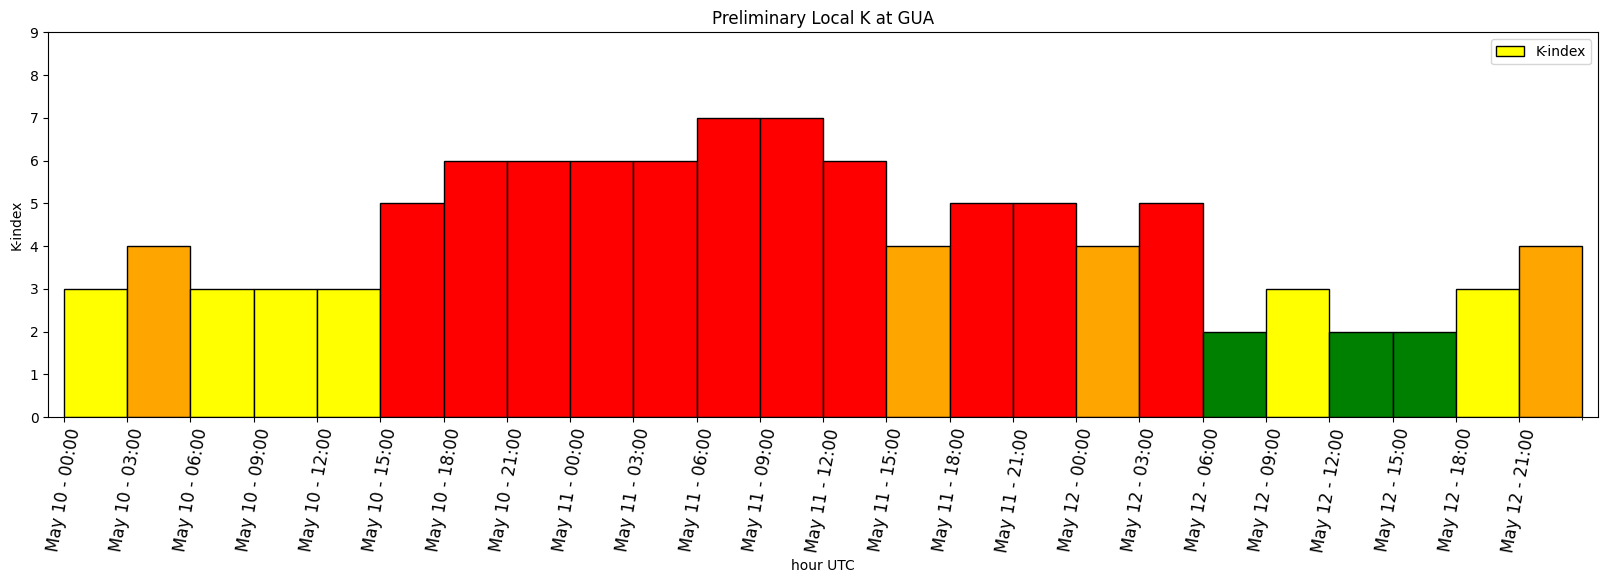

In [ ]:
K1_Var_df.loc[:,'K-index'] = K1_Var_df.loc[:,'Variation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K1_Var_df.loc[:,'XK-index'] = K1_Var_df.loc[:,'XVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K1_Var_df.loc[:,'YK-index'] = K1_Var_df.loc[:,'YVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))

# plotting K-index for checking
K_Var_groups = K1_Var_df.groupby(pd.Grouper(freq='30 D'))
date_int = date_input + pd.Timedelta(0,unit='D')
x_val = K_Var_groups.get_group(date_int).index.strftime('%b %d - %H:%M')
col_values = K_Var_groups.get_group(date_int)['K-index'].values
clrs = ['red'if x >= 5 else 'orange' if x >= 4 else 'yellow' if x >= 3 else 'g' for x in col_values ]
ax = K_Var_groups.get_group(date_int).plot.bar( y='K-index', figsize=(20.0,5.0), rot = 0, align='edge', width=1, edgecolor='k',color=clrs);
ax.set(xlabel='hour UTC', ylabel='K-index', title= 'Preliminary Local K at ' + stat_name)
ax.set_ylim(0,9)
ticks_range = range(0,len(x_val),8)
ax.set_xticklabels(labels =x_val,rotation=80,fontsize=12)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.show()

## **Step 3** Intermediate K-index Calculation  

- Calculate fitting lenghts and intervals
- Calculate hourly means ( for both components)
- Determine Solar Regular ($S_R$) variation or Quiet day curve
- Remove $S_R$ variation
- Calculate the K index (Intermediate)


### Creating preliminary hourly K-index **K Index ($t_i$**) inserting 3h Kindex in each of 3 hours

hourly values, i = 0,1, ..., 23 (preliminary)

The 24 hourly values of K are obtained by assuming that, in each 3-hour interval, the 1-hour K values for each of the three hour-long
subintervals are the same.

In [ ]:
temp_idx = pd.date_range(start=date_input, periods=(total_days-2)*24, freq='H') # create index for target period with hourly frequence
Data1_1hr_df = pd.DataFrame(index=temp_idx) # for hourly data including K-index next S_R curve calculation
Data1_1hr_df['K-index'] = K1_Var_df['K-index'].resample('H').ffill() # change to one hour sample
Data1_1hr_df.fillna(method= 'ffill', inplace=True)
Data1_1hr_df.index = Data1_1hr_df.index + pd.Timedelta(30,unit='m')
del temp_idx

<ipython-input-23-4ba0a5a9a60a>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=date_input, periods=(total_days-2)*24, freq='H') # create index for target period with hourly frequence
<ipython-input-23-4ba0a5a9a60a>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Data1_1hr_df['K-index'] = K1_Var_df['K-index'].resample('H').ffill() # change to one hour sample
<ipython-input-23-4ba0a5a9a60a>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data1_1hr_df.fillna(method= 'ffill', inplace=True)
<ipython-input-23-4ba0a5a9a60a>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

### Calculate fitting lengths and interval for each hour mean

The hourly means of each component are calculated from the magnetic data of target hour plus the data from one day before and after which is the length of $m+n$ minutes, i.e.,

$ \tau_i[min]  = 30 + m(t_i) + n(t_i), i = 0, 1, ..., 23 $

$([t_i-\tau_i, t_i+\tau_i], i = 0, 1, 2, ...,23 $

The number m depends on the local time:

$ m(t_i) = 90, t_i \in [00, 03LT) $ during night

$ m(t_i) =  60, t_i \in [03, 06LT) $ during dawn

$ m(t_i) =   0, t_i \in [06, 18LT) $ during day time hours

$ m(t_i) =  60, t_i \in [18, 21LT) $during dusk

$ m(t_i) = 90, t_i \in [21, 24LT) $ during night

The number $n$ depends on the geomagnetic activity K-index

$n_i[min] = (K_i)^{3.3}, i = 0,1,...,23 $




In [ ]:
Data1_1hr_df['n'] = Data1_1hr_df['K-index'].apply(lambda x: x**(3.3)) # calculate n values
if LT_diff >= 0:
  Data1_1hr_df['Local Time'] = Data1_1hr_df.index.values + pd.Timedelta(abs(LT_diff),unit='h') # local time
else:
  Data1_1hr_df['Local Time'] = Data1_1hr_df.index.values - pd.Timedelta(abs(LT_diff),unit='h') # local time
Data1_1hr_df['m'] = Data1_1hr_df['Local Time'].apply(lambda x: Find_m(x)) # calculate m values
Data1_1hr_df['Time fit length'] = 30 + Data1_1hr_df['n'] + Data1_1hr_df['m'] # For time lenght/spin of each side to calculate mean
Data1_1hr_df['Start Time'] = Data1_1hr_df.index - pd.to_timedelta(Data1_1hr_df['Time fit length'],unit='min').dt.round('1min') # Start time for each mean
Data1_1hr_df['End Time'] = Data1_1hr_df.index + pd.to_timedelta(Data1_1hr_df['Time fit length'],unit='min').dt.round('1min') # End time for each mean

### Calculating hourly means (for both X and Y compoents) including data from both side with time fit lengths



In [ ]:
Data1_1hr_df['X mean'] = np.nan
Data1_1hr_df['Y mean'] = np.nan
for idx in Data1_1hr_df.index:
  Start_time = Data1_1hr_df['Start Time'][idx] # start time to calculate the hourly mean
  End_time = Data1_1hr_df['End Time'][idx]  # end time to calculate the hourly mean

  Data1_1hr_df.loc[idx,'X mean'] = Mag_XY_df['X comp'][Start_time:End_time].mean() # X component hourly mean
  Data1_1hr_df.loc[idx,'Y mean'] = Mag_XY_df['Y comp'][Start_time:End_time].mean() # X component hourly mean

### Determining Solar Regular Variation $S_R$ curve  or Quiet day curve (prelimnary)

 Smoothing 5-th degree harmonic fit to hourly means using FFT and iFFT

Alternatively

 Smoothing using splin polynominal method  


<ipython-input-13-b9f484d1a248>:75: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  time_gap = pd.Timedelta(24*60-1,unit='T')
<ipython-input-26-6107eb2f33b8>:5: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  time_gap = pd.Timedelta(24*60-1,unit='T')


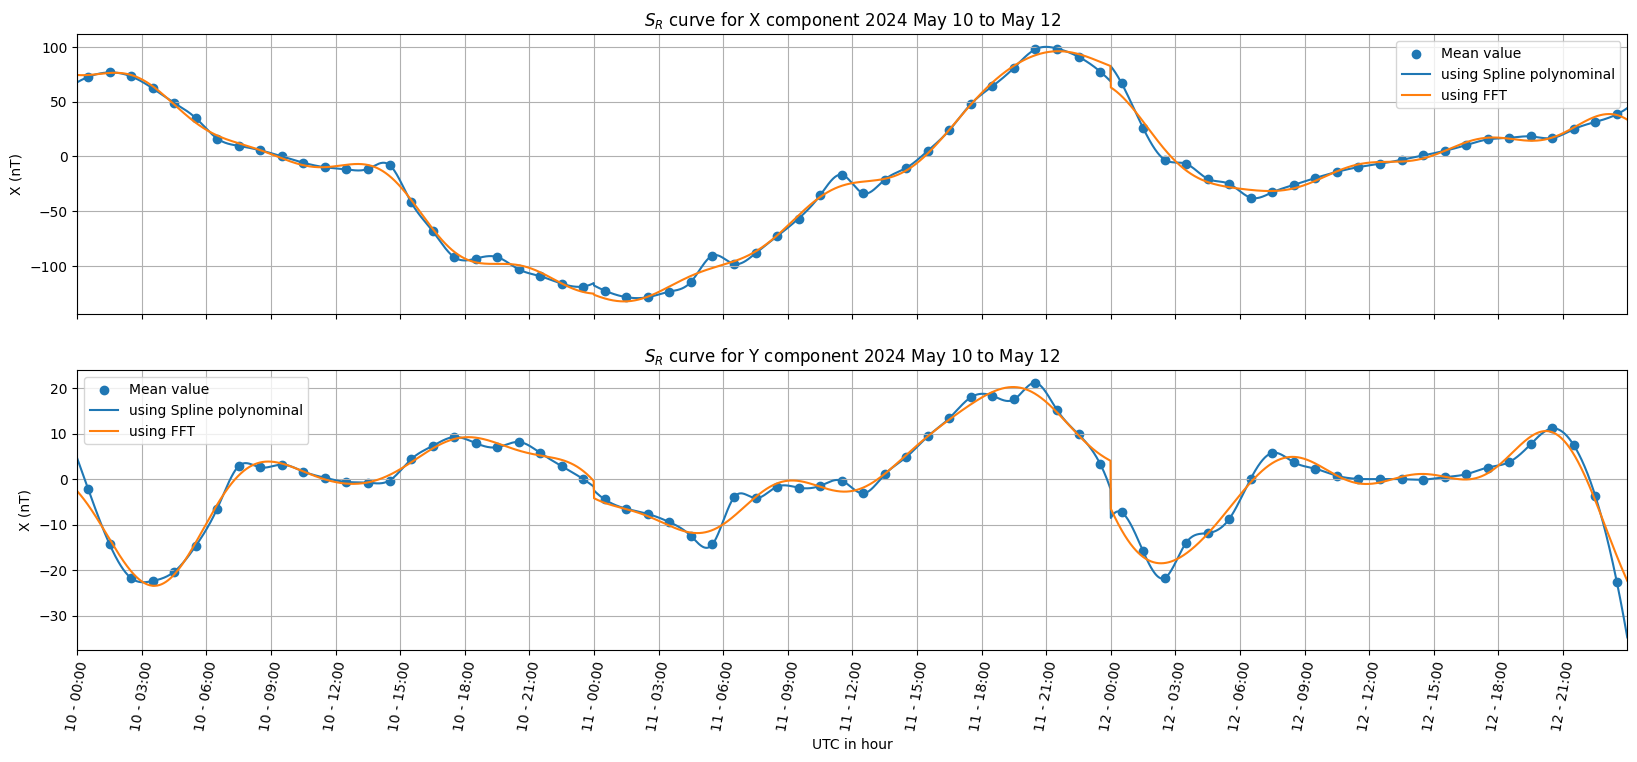

In [ ]:
#SR_curve_smooth(Mean_1hr_df, curve_index, HarmOrder) using FFT and iFFT
SR1_curve_Ser = SR_curve_smooth(Data1_1hr_df[['X mean','Y mean']],Mag_XY_df[time_start:time_end].index , 5)
#Using Spline function
HourlyMean_groups = Data1_1hr_df.groupby(pd.Grouper(freq='D'))
time_gap = pd.Timedelta(24*60-1,unit='T')
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(20.0,8.0), sharex=True)
for idx, group in HourlyMean_groups:
  temp_idx = np.array(group.index.hour.astype(float))+0.5
  temp_Xval = group['X mean'].values
  temp_Yval = group['Y mean'].values
  splX = InterpolatedUnivariateSpline(x=temp_idx, y=temp_Xval, k=3)
  splY = InterpolatedUnivariateSpline(x=temp_idx, y=temp_Yval, k=3)
  dayper_val = np.arange(0,24,1/60)
  temp2_Xval = splX(dayper_val) # create a polynominal function
  temp2_Yval = splY(dayper_val) # create a polynominal function
  SR1_curve_Ser.loc[idx:idx+time_gap,'Splin X'] = temp2_Xval
  SR1_curve_Ser.loc[idx:idx+time_gap,'Splin Y'] = temp2_Yval

ax[0].scatter(Data1_1hr_df.index, Data1_1hr_df['X mean'],label='Mean value')
ax[0].plot(SR1_curve_Ser.index, SR1_curve_Ser['Splin X'],label ='using Spline polynominal' )
ax[0].plot(SR1_curve_Ser.index, SR1_curve_Ser['Smoothed X mean'],label='using FFT')
ax[0].set(ylabel='X (nT)', title= '$S_R$ curve for X component '+ dur_date)
ax[1].set(xlabel='UTC in hour', ylabel='X (nT)', title= '$S_R$ curve for Y component '+ dur_date)
ax[1].scatter(Data1_1hr_df.index, Data1_1hr_df['Y mean'],label='Mean value')
ax[1].plot(SR1_curve_Ser.index, SR1_curve_Ser['Splin Y'],label ='using Spline polynominal' )
ax[1].plot(SR1_curve_Ser.index, SR1_curve_Ser['Smoothed Y mean'],label='using FFT')
ax[0].set_xlim(SR1_curve_Ser.index.min(),SR1_curve_Ser.index.max())
ax[1].set_xlim(SR1_curve_Ser.index.min(),SR1_curve_Ser.index.max())
ax[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
ax[1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
plt.setp(ax[1].get_xticklabels(), rotation=80)
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()

plt.show()
del temp_idx, temp_Xval, temp2_Xval, temp_Yval, temp2_Yval


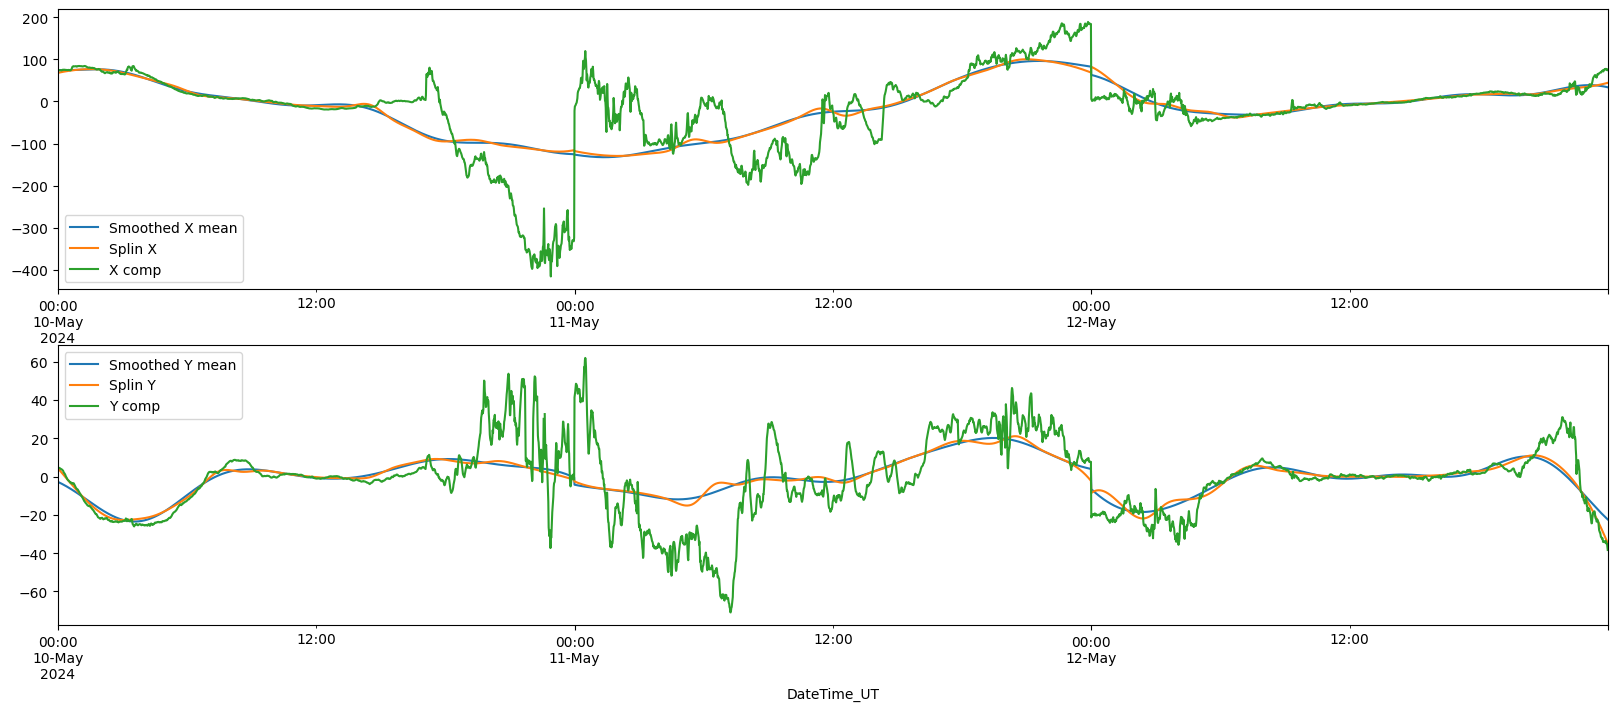

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(20.0,8.0))
SR1_curve_Ser.plot(y=['Smoothed X mean','Splin X'], ax = ax[0])
Mag_XY_df[time_start:time_end].plot(y='X comp', ax = ax[0])
SR1_curve_Ser.plot(y=['Smoothed Y mean','Splin Y'], ax = ax[1])
Mag_XY_df[time_start:time_end].plot(y='Y comp', ax = ax[1])
plt.show()

### Removing $S_R$ variations
Substract $S_R$ variation from original values, both component

You can choose SR curve using FFT method or Splin polynomial method

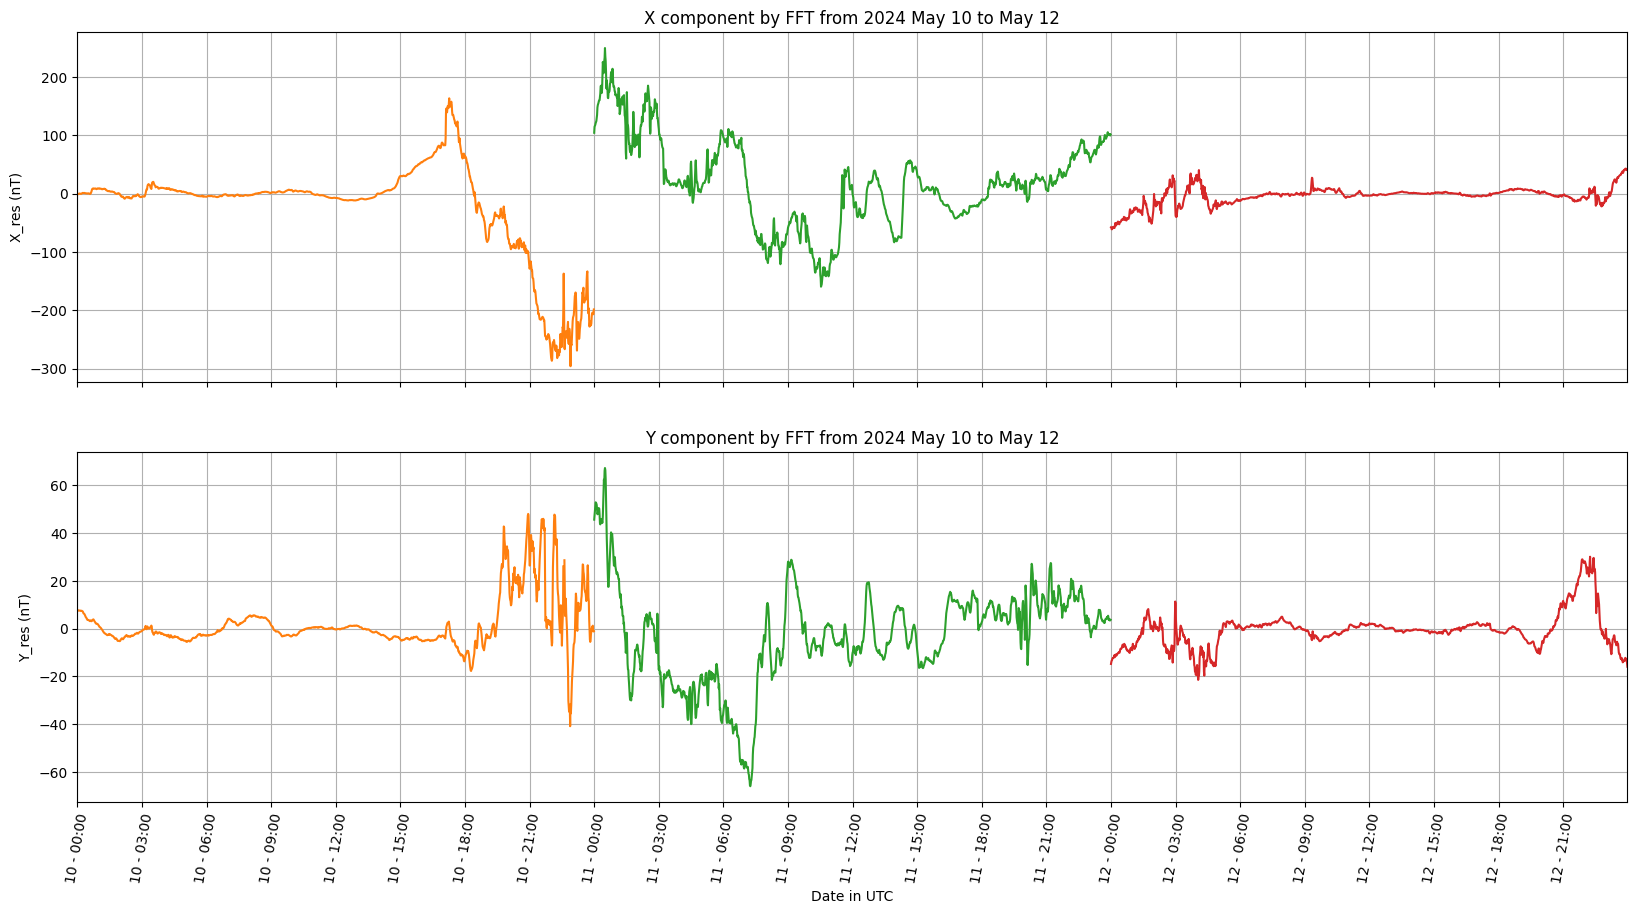

In [ ]:
Mag_XY_df['X comp S1'] = Mag_XY_df['X comp'] - SR1_curve_Ser['Smoothed X mean'] #  SR1_curve_Ser['Splin X'] #
Mag_XY_df['Y comp S1'] = Mag_XY_df['Y comp'] - SR1_curve_Ser['Smoothed Y mean'] #  SR1_curve_Ser['Splin Y'] #

fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(20.0,10.0), sharex=True) #figsize=(20.0,8.0)
Mag_XY_df_groups = Mag_XY_df.groupby(pd.Grouper(freq='D'))
for idx, group  in Mag_XY_df_groups:
  axs[0].plot(group.index, group['X comp S1'])
  axs[1].plot(group.index, group['Y comp S1'])
axs[0].set( ylabel='X_res (nT)', title= 'X component by FFT from ' + dur_date)
axs[1].set(xlabel='Date in UTC', ylabel='Y_res (nT)', title= 'Y component by FFT from ' + dur_date)
axs[0].set_xlim(Mag_XY_df[time_start:time_end].index[0], Mag_XY_df[time_start:time_end].index[-1])
axs[1].set_xlim(Mag_XY_df[time_start:time_end].index[0], Mag_XY_df[time_start:time_end].index[-1])
axs[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
axs[1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
axs[0].grid()
axs[1].grid()
plt.setp(axs[1].get_xticklabels(), rotation=80)

plt.show()

### Calculating Variation Range for K index

- Separate 8 segment with 3 hours length
- Find the max and min of X/Y component of magnetic field in each segment
- Calculation variation range which is the difference between max and min.

In [ ]:
temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
# new data frame for  X variation, Y Variation,highest Variation and K index,
K2_Var_df = pd.DataFrame(columns=['XVariation','YVariation','Variation','XK-index','YK-index','K-index'],index=temp_idx)
K2_Var_df.index.name = 'DateTime UTC'
# X component varation
Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp S1'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Xcomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K2_Var_df['XVariation'] = temp_df

# Y component varation
Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp S1'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Ycomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K2_Var_df['YVariation'] = temp_df
del temp_idx, temp_df

# Find the max variation range between X and Y
K2_Var_df['Variation'] = K2_Var_df.apply(lambda x: max(x['XVariation'],x['YVariation']), axis=1 )

<ipython-input-29-54e5434ebed5>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
<ipython-input-29-54e5434ebed5>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp S1'].groupby(pd.Grouper(freq='3 H'))
<ipython-input-29-54e5434ebed5>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp S1'].groupby(pd.Grouper(freq='3 H'))


### Calculating Intermediate Local **K index**

(All calculation are in Rrang_Kindex Function)
- Generate the range classes table according to K9_Limit value which is depend on the station's location
- Map the variation range to the K-index value according to the range classes table

'K2_Var_df' is the dataframe with Intermediate Local K-index and varation ranges


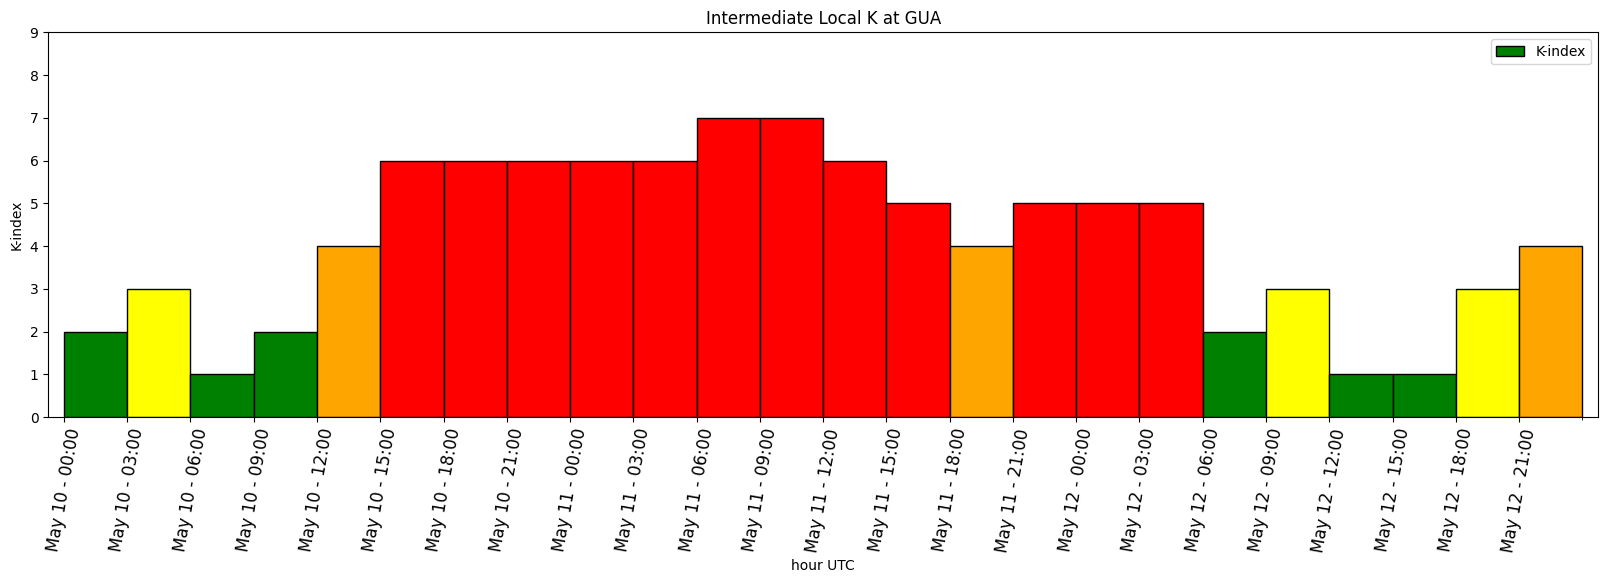

In [ ]:
K2_Var_df.loc[:,'K-index'] = K2_Var_df.loc[:,'Variation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K2_Var_df.loc[:,'XK-index'] = K2_Var_df.loc[:,'XVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K2_Var_df.loc[:,'YK-index'] = K2_Var_df.loc[:,'YVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))

# plotting K-index for checking
K_Var_groups = K2_Var_df.groupby(pd.Grouper(freq='30 D'))
date_int = date_input + pd.Timedelta(0,unit='D')
x_val = K_Var_groups.get_group(date_int).index.strftime('%b %d - %H:%M')
col_values = K_Var_groups.get_group(date_int)['K-index'].values
clrs = ['red'if x >= 5 else 'orange' if x >= 4 else 'yellow' if x >= 3 else 'g' for x in col_values ]
ax = K_Var_groups.get_group(date_int).plot.bar( y='K-index', figsize=(20.0,5.0), rot = 0, align='edge', width=1, edgecolor='k',color=clrs);
ax.set(xlabel='hour UTC', ylabel='K-index', title= 'Intermediate Local K at ' + stat_name)
ax.set_ylim(0,9)
ticks_range = range(0,len(x_val),8)
ax.set_xticklabels(labels =x_val,rotation=80,fontsize=12)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))

plt.show()

## **Step 4** Final K index Calculation

- Calculate fitting lenghts and intervals
- Calculate hourly means ( for both components)
- Determine Solar Regular ($S_R$) variation or Quiet day curve
- Remove $S_R$ variation
- Calculate the K index (Final)

### Creating preliminary hourly K-index **K Index ($t_i$**) inserting 3h Kindex in each of 3 hours

hourly values, i = 0,1, ..., 23 (preliminary)

The 24 hourly values of K are obtained by assuming that, in each 3-hour interval, the 1-hour K values for each of the three hour-long
subintervals are the same.

In [ ]:
temp_idx = pd.date_range(start=date_input, periods=(total_days-2)*24, freq='H') # create index for target period with hourly frequence
Data2_1hr_df = pd.DataFrame(index=temp_idx) # for hourly data including K-index next S_R curve calculation
Data2_1hr_df['K-index'] = K2_Var_df['K-index'].resample('H').ffill() # change to one hour sample
Data2_1hr_df.fillna(method= 'ffill', inplace=True)
Data2_1hr_df.index = Data2_1hr_df.index + pd.Timedelta(30,unit='m')
del temp_idx

<ipython-input-31-46c335f29eb3>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=date_input, periods=(total_days-2)*24, freq='H') # create index for target period with hourly frequence
<ipython-input-31-46c335f29eb3>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Data2_1hr_df['K-index'] = K2_Var_df['K-index'].resample('H').ffill() # change to one hour sample
<ipython-input-31-46c335f29eb3>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data2_1hr_df.fillna(method= 'ffill', inplace=True)
<ipython-input-31-46c335f29eb3>:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_sil

### Calculate fitting lengths and interval for each hour mean

The hourly means of each component are calculated from the magnetic data of target hour plus the data from one day before and after which is the length of $m+n$ minutes, i.e.,

$ \tau_i[min]  = 30 + m(t_i) + n(t_i), i = 0, 1, ..., 23 $

$([t_i-\tau_i, t_i+\tau_i], i = 0, 1, 2, ...,23 $

The number m depends on the local time:

$ m(t_i) = 90, t_i \in [00, 03LT) $ during night

$ m(t_i) =  60, t_i \in [03, 06LT) $ during dawn

$ m(t_i) =   0, t_i \in [06, 18LT) $ during day time hours

$ m(t_i) =  60, t_i \in [18, 21LT) $during dusk

$ m(t_i) = 90, t_i \in [21, 24LT) $ during night

The number $n$ depends on the geomagnetic activity K-index

$n_i[min] = (K_i)^{3.3}, i = 0,1,...,23 $




In [ ]:
Data2_1hr_df['n'] = Data2_1hr_df['K-index'].apply(lambda x: x**(3.3)) # calculate n values
if LT_diff >= 0:
  Data2_1hr_df['Local Time'] = Data1_1hr_df.index.values + pd.Timedelta(abs(LT_diff),unit='h') # local time
else:
  Data2_1hr_df['Local Time'] = Data1_1hr_df.index.values - pd.Timedelta(abs(LT_diff),unit='h') # local time
Data2_1hr_df['m'] = Data2_1hr_df['Local Time'].apply(lambda x: Find_m(x)) # calculate m values
Data2_1hr_df['Time fit length'] = 30 + Data2_1hr_df['n'] + Data2_1hr_df['m'] # For time lenght/spin of each side to calculate mean
Data2_1hr_df['Start Time'] = Data2_1hr_df.index - pd.to_timedelta(Data2_1hr_df['Time fit length'],unit='min').dt.round('1min') # Start time for each mean
Data2_1hr_df['End Time'] = Data2_1hr_df.index + pd.to_timedelta(Data2_1hr_df['Time fit length'],unit='min').dt.round('1min') # End time for each mean

### Calculating hourly means (for both X and Y compoents) including data from both side with time fit lengths



In [ ]:
Data2_1hr_df['X mean'] = np.nan
Data2_1hr_df['Y mean'] = np.nan
for idx in Data2_1hr_df.index:
  Start_time = Data2_1hr_df['Start Time'][idx] # start time to calculate the hourly mean
  End_time = Data2_1hr_df['End Time'][idx]  # end time to calculate the hourly mean

  Data2_1hr_df.loc[idx,'X mean'] = Mag_XY_df['X comp'][Start_time:End_time].mean() # X component hourly mean
  Data2_1hr_df.loc[idx,'Y mean'] = Mag_XY_df['Y comp'][Start_time:End_time].mean() # X component hourly mean

### Determining Solar Regular Variation $S_R$ curve  or Quiet day curve (Intermediate)


 Smoothing 5-th degree harmonic fit to hourly means using FFT and iFFT

Alternatively

 Smoothing using splin polynominal method

In [ ]:
#SR_curve_smooth(Mean_1hr_df, curve_index, HarmOrder)
SR2_curve_Ser = SR_curve_smooth(Data2_1hr_df[['X mean','Y mean']],Mag_XY_df[time_start:time_end].index , 5)
#Using Spline function
HourlyMean_groups = Data2_1hr_df.groupby(pd.Grouper(freq='D'))
time_gap = pd.Timedelta(24*60-1,unit='T')
for idx, group in HourlyMean_groups:
  temp_idx = np.array(group.index.hour.astype(float))+0.5
  temp_Xval = group['X mean'].values
  temp_Yval = group['Y mean'].values
  splX = InterpolatedUnivariateSpline(x=temp_idx, y=temp_Xval, k=3)
  splY = InterpolatedUnivariateSpline(x=temp_idx, y=temp_Yval, k=3)
  dayper_val = np.arange(0,24,1/60)
  temp2_Xval = splX(dayper_val) # create a polynominal function
  temp2_Yval = splY(dayper_val) # create a polynominal function
  SR2_curve_Ser.loc[idx:idx+time_gap,'Splin X'] = temp2_Xval
  SR2_curve_Ser.loc[idx:idx+time_gap,'Splin Y'] = temp2_Yval

del temp_idx, temp_Xval, temp2_Xval, temp_Yval, temp2_Yval


<ipython-input-13-b9f484d1a248>:75: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  time_gap = pd.Timedelta(24*60-1,unit='T')
<ipython-input-34-1e5978eb78e7>:5: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  time_gap = pd.Timedelta(24*60-1,unit='T')


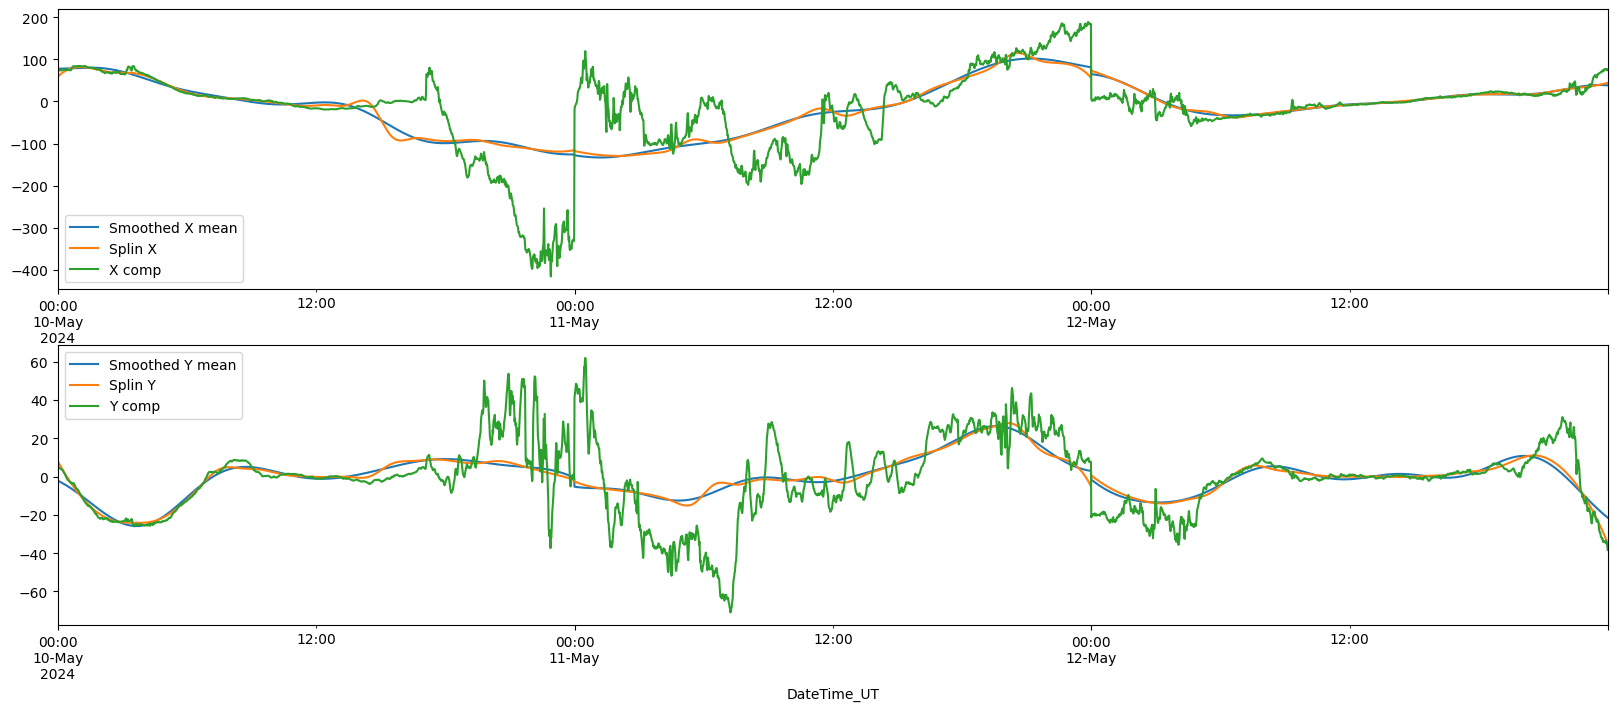

In [ ]:
# Ploting raw X/Y component and SR curves fromt who method

fig,ax = plt.subplots(2,1,figsize=(20.0,8.0))
SR2_curve_Ser.plot(y=['Smoothed X mean','Splin X'], ax = ax[0])
Mag_XY_df[time_start:time_end].plot(y='X comp', ax = ax[0])
SR2_curve_Ser.plot(y=['Smoothed Y mean','Splin Y'], ax = ax[1])
Mag_XY_df[time_start:time_end].plot(y='Y comp', ax = ax[1])
plt.show()

### Removing $S_R$ variations
Substract $S_R$ variation from original values, both component

You can choose SR curve using FFT method or Splin polynomial method

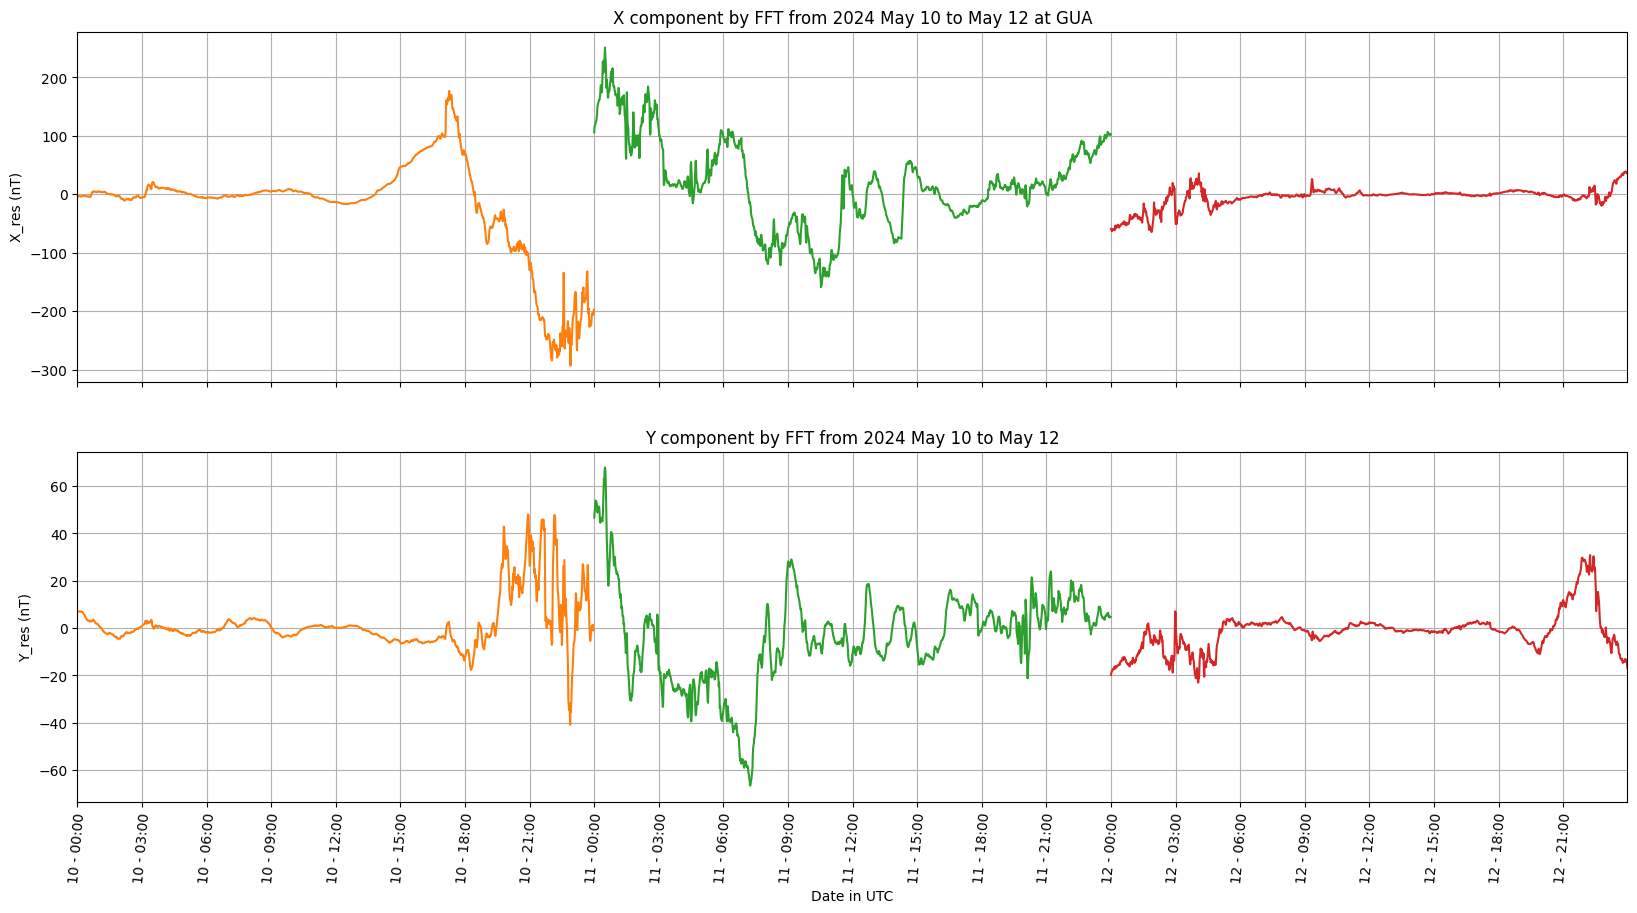

In [ ]:
# To calculate the residual Xcomp after Substracting SR_curv

Mag_XY_df['X comp S2'] = Mag_XY_df['X comp'] -   SR2_curve_Ser['Smoothed X mean'] # SR2_curve_Ser['Splin X'] #
Mag_XY_df['Y comp S2'] = Mag_XY_df['Y comp'] -   SR2_curve_Ser['Smoothed Y mean'] #  SR2_curve_Ser['Splin Y'] #

fig,axs = plt.subplots(nrows=2, ncols=1, figsize=(20.0,10.0), sharex=True) #figsize=(20.0,8.0)
Mag_XY_df_groups = Mag_XY_df.groupby(pd.Grouper(freq='D'))
for idx, group  in Mag_XY_df_groups:
  axs[0].plot(group.index, group['X comp S2'])
  axs[1].plot(group.index, group['Y comp S2'])
axs[0].set( ylabel='X_res (nT)', title= 'X component by FFT from ' + dur_date + ' at ' + stat_name)
axs[1].set(xlabel='Date in UTC', ylabel='Y_res (nT)', title= 'Y component by FFT from ' + dur_date)
axs[0].set_xlim(Mag_XY_df[time_start:time_end].index[0], Mag_XY_df[time_start:time_end].index[-1])
axs[1].set_xlim(Mag_XY_df[time_start:time_end].index[0], Mag_XY_df[time_start:time_end].index[-1])
axs[0].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
axs[1].xaxis.set_major_locator(mticker.MultipleLocator(1/8))
axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%d - %H:%M'))
axs[0].grid()
axs[1].grid()
plt.setp(axs[1].get_xticklabels(), rotation=85)

plt.show()

### Calculating Variation Range for K index

- Separate 8 segment with 3 hours length
- Find the max and min of X/Y component of magnetic field in each segment
- Calculation variation range which is the difference between max and min.

In [ ]:
temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
# new data frame for  X variation, Y Variation,highest Variation and K index,
K3_Var_df = pd.DataFrame(columns=['XVariation','YVariation','Variation','XK-index','YK-index','K-index'],index=temp_idx)
K3_Var_df.index.name = 'DateTime UTC'
# X component varation
Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp S2'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Xcomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K3_Var_df['XVariation'] = temp_df

# Y component varation
Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp S2'].groupby(pd.Grouper(freq='3 H'))
temp_df = []
for idx, group in Ycomp_groups:
  rng = abs(group.max() - group.min())
  temp_df.append(rng)
K3_Var_df['YVariation'] = temp_df

del temp_idx, temp_df
# Find the max variation range between X and Y
K3_Var_df['Variation'] = K3_Var_df.apply(lambda x: max(x['XVariation'],x['YVariation']), axis=1 )

<ipython-input-37-c5b559ef2c9b>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
<ipython-input-37-c5b559ef2c9b>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Xcomp_groups = Mag_XY_df[time_start:time_end]['X comp S2'].groupby(pd.Grouper(freq='3 H'))
<ipython-input-37-c5b559ef2c9b>:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  Ycomp_groups = Mag_XY_df[time_start:time_end]['Y comp S2'].groupby(pd.Grouper(freq='3 H'))


### Calculating  **Final Local** **K index**

(All calculation are in Rrang_Kindex Function)
- Generate the range classes table according to K9_Limit value which is depend on the station's location
- Map the variation range to the K-index value according to the range classes table

'K3_Var_df' is the dataframe with Final Local K-index and varation ranges


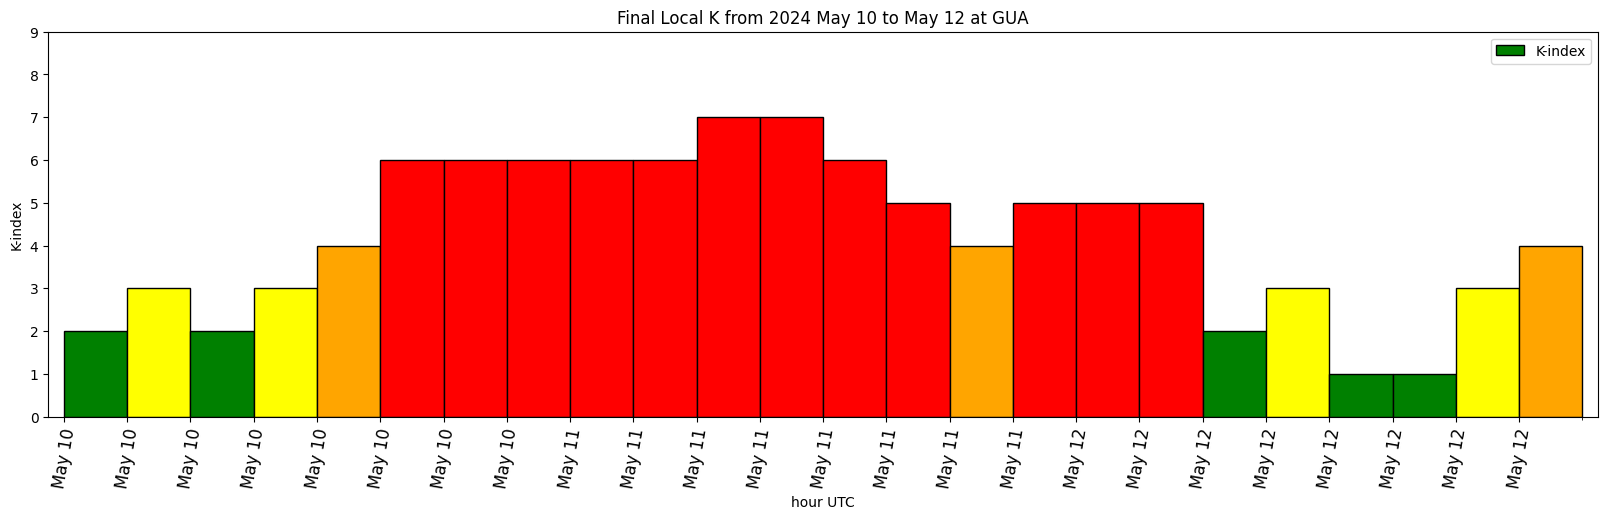

In [ ]:
K3_Var_df.loc[:,'K-index'] = K3_Var_df.loc[:,'Variation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K3_Var_df.loc[:,'XK-index'] = K3_Var_df.loc[:,'XVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))
K3_Var_df.loc[:,'YK-index'] = K3_Var_df.loc[:,'YVariation'].apply(lambda x: Rang_Kindex(x,K9_limit))

# plotting K-index for checking
K_Var_groups = K3_Var_df.groupby(pd.Grouper(freq='30 D'))
date_int = date_input + pd.Timedelta(0,unit='D')
x_val = K_Var_groups.get_group(date_int).index.strftime('%b %d')
col_values = K_Var_groups.get_group(date_int)['K-index'].values
clrs = ['red'if x >= 5 else 'orange' if x >= 4 else 'yellow' if x >= 3 else 'g' for x in col_values ]
ax = K_Var_groups.get_group(date_int).plot.bar( y='K-index', figsize=(20.0,5.0), rot = 0, align='edge', width=1, edgecolor='k',color=clrs);
ax.set(xlabel='hour UTC', ylabel='K-index', title= 'Final Local K from ' + dur_date + ' at ' + stat_name)
ax.set_ylim(0,9)
ticks_range = range(0,len(x_val),8)
ax.set_xticklabels(labels =x_val,rotation=80,fontsize=12)
ax.xaxis.set_minor_locator(plt.MultipleLocator(1))
plt.show()

### Reading the Kp Index from
ftp://ftp.gfz-potsdam.de/pub/home/obs/kp-ap/wdc/yearly/

Kp, Sigma Kp, ap and Ap indices on each day are shown in one record.

<TABLE CELLPADDING=6 BORDER>
<TR><TH>Column</TH><TH>Contents (Format)</TH></TR>
<TR ALIGN="LEFT"><TH>1-8</TH><TH>Date in format YYYYMMDD,
(I4.4,2I2.2)</TH></TR>
<TR ALIGN="LEFT"><TH>9</TH><TH>Space (1X)</TH></TR>
<TR ALIGN="LEFT"><TH>10-25</TH><TH>8 Kp values [0, 0+, 1- ..... 9-, 9]
(8A2)</TH></TR>
<TR ALIGN="LEFT"><TH>26-28</TH><TH><FONT FACE="SYMBOL">S</FONT>Kp
(A3)</TH></TR>
<TR ALIGN="LEFT"><TH>29-52</TH><TH>8 ap values [0, 2, 3, 4, ...... ]
(8I3)</TH></TR>
<TR ALIGN="LEFT"><TH>53-55</TH><TH>Ap (I3)</TH></TR>
</TABLE>

---
Alternatively, can download FTP site from [NOAA](https://www.ngdc.noaa.gov/stp/GEOMAG/kp_ap.html)
ftp://ftp.ngdc.noaa.gov/STP/GEOMAGNETIC_DATA/INDICES/KP_AP

Three-hour-range Index Kp
Ks indices isolate solar particle effects on the earth's magnetic field; over a 3-hour period, they classify into disturbance levels the range of variation of the more unsettled horizontal field component. Each activity level relates almost logarithmically to its corresponding disturbance amplitude. Three-hour indices discriminate conservatively between true magnetic field perturbations and the quiet-day variations produced by ionospheric currents.


---


Ks indices range in 28 steps from 0 (quiet) to 9 (greatly disturbed) with fractional parts expressed in thirds of a unit. A Ks-value equal to 27, for example, means 2 and 2/3 or 3-; a Ks-value equal to 30 means 3 and 0/3 or 3 exactly; and a Ks-value equal to 33 means 3 and 1/3 or 3+. The arithmetic mean of the Ks values scaled at the 13 observatories listed above gives Kp.

In [ ]:
# Read Kp-index data file from server
kp_target = 'kp'+ date_input.strftime('%Y') + '.wdc'
kpfile_local = os.path.join(os.getcwd(),'Magnetometerdata', kp_target)
if not os.path.isfile(kpfile_local):
  print('File is not exist')
  Kp_download(kp_target,kpfile_local) # Kp index dataframe

Kp_df = Kp_read(kpfile_local) # Kp index dataframe

# Select interest month
start_d = date_input # pd.to_datetime('2017-01-01')
int_prd = pd.date_range(start=start_d, periods=num_day )
int_kp_df = Kp_df.loc[int_prd].copy()
# Creating Kp index for one month long
temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
temp_df = pd.DataFrame(dtype=float)
for i in range(len(int_kp_df.index)):
  temp = int_kp_df['Ks_3hr'][i]
  temp_array = np.array([])
  for j in range(0,len(temp),2):
    temp_array = np.append(temp_array, float(temp[j:j+2])/10)
  temp_df = pd.concat([temp_df,pd.DataFrame(temp_array)])

temp_df.index = temp_idx
K3_Var_df.loc[:,'Kp-index'] = temp_df[0] # add into last K value dataframe

File is not exist
Kp index file downloading is finished


<ipython-input-14-32d3dca27daf>:74: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  kp_df['Date_UT'] = pd.to_datetime(kp_df['Date_UT'].apply(lambda x: re.sub(r'\s','0',x)), yearfirst=True)
<ipython-input-39-3935d1209189>:15: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp_idx = pd.date_range(start=time_start, end = time_end, freq='3 H') # create index for new dataframe
<ipython-input-39-3935d1209189>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = int_kp_df['Ks_3hr'][i]


### Ploting Kp index Vs K index

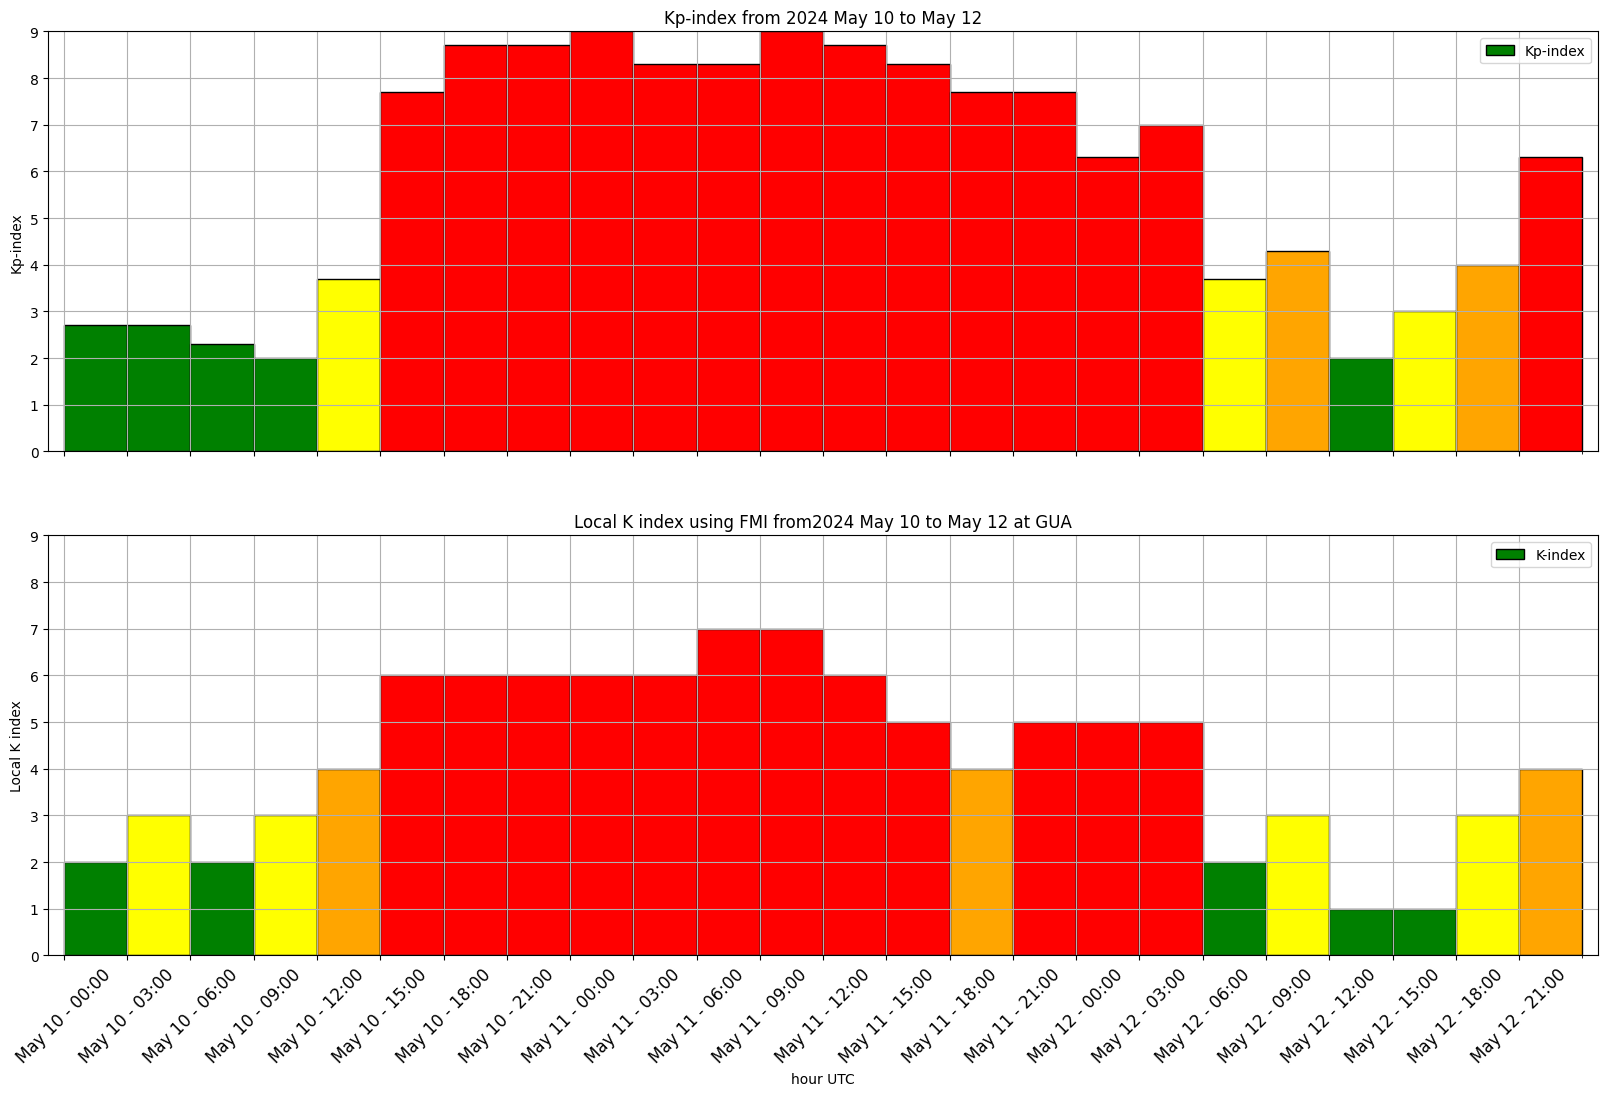

In [ ]:
fig,axs = plt.subplots(nrows =2, ncols=1, figsize=(20.0,12.0),sharex=True)
K_Var_groups = K3_Var_df.groupby(pd.Grouper(freq='30 D'))

date_int = date_input + pd.Timedelta(0,unit='D')
x_val = K_Var_groups.get_group(date_int).index.strftime('%b %d - %H:%M')
col_Kpvalues = K_Var_groups.get_group(date_int)['Kp-index'].values
col_Kvalues = K_Var_groups.get_group(date_int)['K-index'].values

clrs_Kp = ['red'if x >= 5 else 'orange' if x >= 4 else 'yellow' if x >= 3 else 'g' for x in col_Kpvalues ]
clrs_K = ['red'if x >= 5 else 'orange' if x >= 4 else 'yellow' if x >= 3 else 'g' for x in col_Kvalues ]

K_Var_groups.get_group(date_int).plot.bar( y='Kp-index', rot = 0, align='edge', width=1, edgecolor='k',color=clrs_Kp, ax=axs[0]);
K_Var_groups.get_group(date_int).plot.bar( y='K-index', rot = 0, align='edge', width=1, edgecolor='k',color=clrs_K, ax=axs[1]);
axs[0].set(ylabel='Kp-index', title= 'Kp-index from ' + dur_date)
axs[1].set(xlabel='hour UTC', ylabel='Local K index', title= 'Local K index using FMI from' + dur_date + ' at ' + stat_name)
axs[0].set_ylim(0,9)
axs[1].set_ylim(0,9)
ticks_range = range(0,len(x_val),8)
axs[1].set_xticklabels(labels =x_val,rotation=45,fontsize=12)

axs[0].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[1].xaxis.set_minor_locator(plt.MultipleLocator(1))
axs[0].grid()
axs[1].grid()
plt.show()

### Difference between K-index and Kp-index

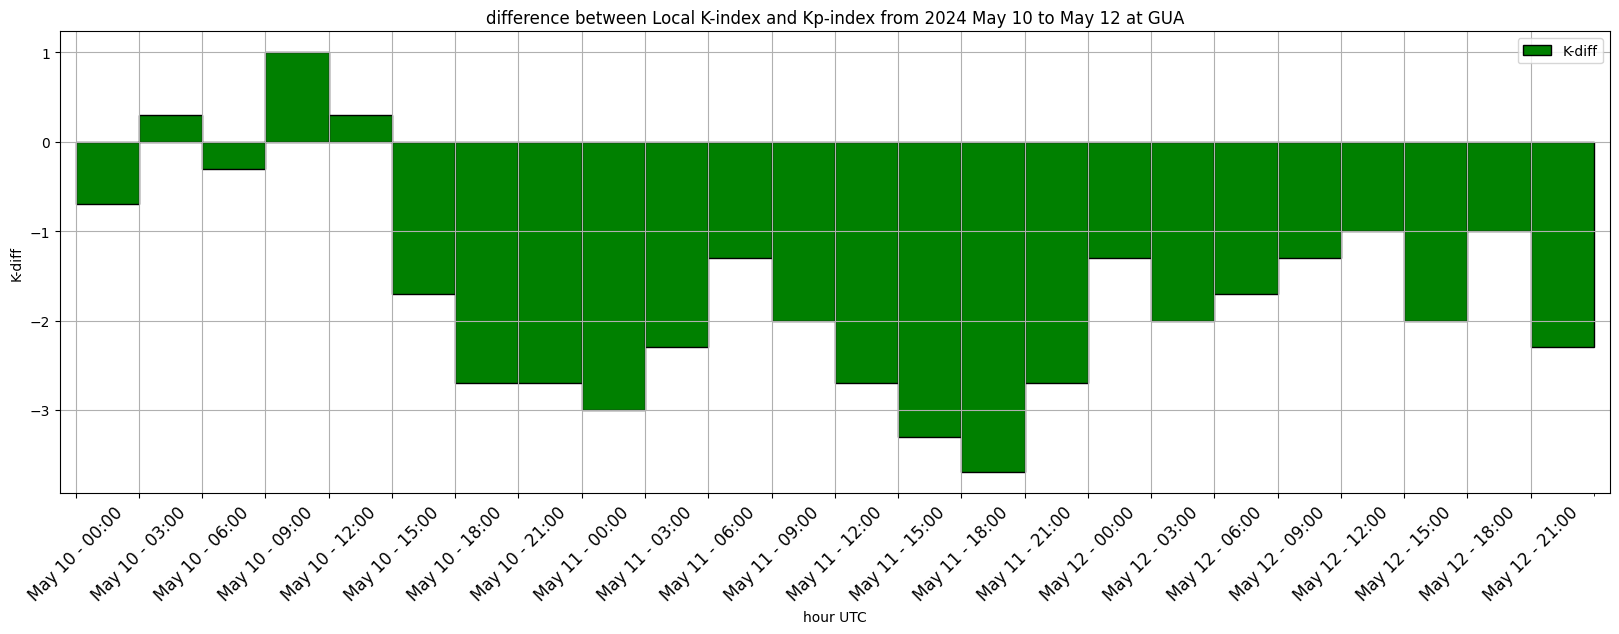

In [ ]:
K3_Var_df['K-diff'] = K3_Var_df.loc[:,'K-index']-K3_Var_df.loc[:,'Kp-index']
fig,axs = plt.subplots(nrows =1, ncols=1, figsize=(20.0,6.0),sharex=False)
K3_Var_groups = K3_Var_df.groupby(pd.Grouper(freq='30 D'))

date_int = date_input + pd.Timedelta(0,unit='D')
x_val = K3_Var_groups.get_group(date_int).index.strftime('%b %d - %H:%M')
col_Kpvalues = K3_Var_groups.get_group(date_int)['K-diff'].values

clrs_Kp = ['red'if x >= 4 else 'orange' if x >= 3 else 'yellow' if x >= 2 else 'g' for x in col_Kpvalues ]


K3_Var_groups.get_group(date_int).plot.bar( y='K-diff', rot = 0, align='edge', width=1, edgecolor='k',color=clrs_Kp, ax=axs);
axs.set(xlabel='hour UTC', ylabel='K-diff', title= 'difference between Local K-index and Kp-index from ' + dur_date + ' at ' + stat_name)
#axs.set_ylim(0,5)
axs.set_xticklabels(labels =x_val,rotation=45,fontsize=12)
axs.xaxis.set_minor_locator(plt.MultipleLocator(1))
axs.grid()
plt.show()

## Saving the output data

The output excel file can be found in local folder

In [ ]:
# # To create csv file for further process
SR_file = os.path.join(os.getcwd(),stat_name +'FMISRcurve'+ date_input.strftime('%Y%B%d') + '.csv')
Kind_file = os.path.join(os.getcwd(),stat_name +'FMIKindex'+ date_input.strftime('%Y%B%d') + '.csv')
SR2_curve_Ser.to_csv(SR_file,index=True, header=True)
K3_Var_df.to_csv(Kind_file,index=True, header=True)


In [ ]:
# # To create excel
# exc_file = os.path.join(os.getcwd() ,stat_name +'FMISRandKindex'+ date_input.strftime('%Y%B%d') + '.xlsx')
# with pd.ExcelWriter(exc_file) as writer:
#   K3_Var_df.to_excel(writer,sheet_name = 'K-index',header=True)
#   SR2_curve_Ser.to_excel(writer,sheet_name = 'Inter SR curve',header=True)
#   K2_Var_df.to_excel(writer,sheet_name = 'Inter K-index',header=True)
#   SR1_curve_Ser.to_excel(writer,sheet_name = 'Pre SR curve',header=True)
#   K1_Var_df.to_excel(writer,sheet_name = 'Pre K-index',header=True)